In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=07903758ae48fc079ddec2b65ca29a640119014d0b1d6b54da99549f2286821f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull
from pyspark.mllib.stat import Statistics
from pyspark.sql import Row
from pyspark.sql.types import TimestampType
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, mean, last, first
from pyspark.sql.functions import to_date
from datetime import datetime, timedelta
from pyspark.ml.feature import Imputer
from pyspark.sql.types import StructType, StructField, TimestampType
from pyspark.sql.types import DateType, StringType
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql.functions import to_timestamp
import pyspark.sql.functions as sqlf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
spark = SparkSession.builder \
    .appName("Air Quality Index Prediction") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

df = spark.read.csv('/content/sample_data/city_hour.csv', header=True, inferSchema=True)
df = df.withColumn("Datetime", to_timestamp(col("Datetime"), 'MM/dd/yyyy HH:mm'))
df.show()

+---------+-------------------+-----+----+----+-----+-----+----+----+------+------+
|     City|           Datetime|PM2.5|PM10|  NO|  NO2|  NOx| NH3|  CO|   SO2|    O3|
+---------+-------------------+-----+----+----+-----+-----+----+----+------+------+
|Ahmedabad|2015-01-01 01:00:00| NULL|NULL| 1.0|40.01|36.37|NULL| 1.0|122.07|  NULL|
|Ahmedabad|2015-01-01 02:00:00| NULL|NULL|0.02|27.75|19.73|NULL|0.02|  85.9|  NULL|
|Ahmedabad|2015-01-01 03:00:00| NULL|NULL|0.08|19.32|11.08|NULL|0.08| 52.83|  NULL|
|Ahmedabad|2015-01-01 04:00:00| NULL|NULL| 0.3|16.45|  9.2|NULL| 0.3| 39.53|153.58|
|Ahmedabad|2015-01-01 05:00:00| NULL|NULL|0.12| 14.9| 7.85|NULL|0.12| 32.63|  NULL|
|Ahmedabad|2015-01-01 06:00:00| NULL|NULL|0.33|15.95|10.82|NULL|0.33| 29.87| 64.25|
|Ahmedabad|2015-01-01 07:00:00| NULL|NULL|0.45|15.94|12.47|NULL|0.45| 27.41|191.96|
|Ahmedabad|2015-01-01 08:00:00| NULL|NULL|1.03|16.66|16.48|NULL|1.03| 20.92|177.21|
|Ahmedabad|2015-01-01 09:00:00| NULL|NULL|1.47|16.25|18.02|NULL|1.47| 16.45|

In [ ]:
rdd = df.rdd
print(rdd.take(5))

[Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 1, 0), PM2.5=None, PM10=None, NO=1.0, NO2=40.01, NOx=36.37, NH3=None, CO=1.0, SO2=122.07, O3=None), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 2, 0), PM2.5=None, PM10=None, NO=0.02, NO2=27.75, NOx=19.73, NH3=None, CO=0.02, SO2=85.9, O3=None), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 3, 0), PM2.5=None, PM10=None, NO=0.08, NO2=19.32, NOx=11.08, NH3=None, CO=0.08, SO2=52.83, O3=None), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 4, 0), PM2.5=None, PM10=None, NO=0.3, NO2=16.45, NOx=9.2, NH3=None, CO=0.3, SO2=39.53, O3=153.58), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 5, 0), PM2.5=None, PM10=None, NO=0.12, NO2=14.9, NOx=7.85, NH3=None, CO=0.12, SO2=32.63, O3=None)]


In [ ]:
num_rows = rdd.count()
schema = df.schema

print("Shape of RDD: ({}, {})".format(num_rows, len(schema)))

for field in schema:
    print("Column: {}, Data Type: {}".format(field.name, field.dataType))

Shape of RDD: (707875, 11)
Column: City, Data Type: StringType()
Column: Datetime, Data Type: TimestampType()
Column: PM2.5, Data Type: DoubleType()
Column: PM10, Data Type: DoubleType()
Column: NO, Data Type: DoubleType()
Column: NO2, Data Type: DoubleType()
Column: NOx, Data Type: DoubleType()
Column: NH3, Data Type: DoubleType()
Column: CO, Data Type: DoubleType()
Column: SO2, Data Type: DoubleType()
Column: O3, Data Type: DoubleType()


**Interpretation**


*   From the above information, dataset have 1 Categorical variables and 10 Numerical variables.
*  The data have total 11 variables and 707875 records.



In [ ]:
def compute_summary_statistics(rdd):
    # Calculate count, mean, sum, minimum, maximum, and standard deviation for each column
    summary_stats = rdd.map(lambda row: [(col, float(cell)) for col, cell in row.asDict().items() if isinstance(cell, (int, float))]) \
                       .filter(lambda x: len(x) > 0) \
                       .cache()

    column_count = summary_stats.count()
    summary_stats = summary_stats.flatMap(lambda x: x) \
                                 .groupByKey() \
                                 .map(lambda x: (x[0], (len(x[1]), sum(x[1]), sum(x[1])/len(x[1]), min(x[1]), max(x[1]), np.std(list(x[1])), np.percentile(list(x[1]), 25), np.percentile(list(x[1]), 75)))) \
                                 .collect()

    # Print summary statistics for each column
    for column, (count, total, mean, minimum, maximum, std_dev, q1, q3) in summary_stats:
        print("Summary statistics for column '{}':".format(column))
        print("  Count: {}".format(count))
        print("  Total: {}".format(total))
        print("  Mean: {}".format(mean))
        print("  Minimum: {}".format(minimum))
        print("  Maximum: {}".format(maximum))
        print("  Standard Deviation: {}".format(std_dev))
        print("  1st Quartile (Q1): {}".format(q1))
        print("  3rd Quartile (Q3): {}".format(q3))
        print()

# Call the function to compute summary statistics
compute_summary_statistics(rdd)


Summary statistics for column 'NO':
  Count: 591243
  Total: 10300490.950000027
  Mean: 17.42175543727372
  Minimum: 0.01
  Maximum: 499.99
  Standard Deviation: 32.09518354653461
  1st Quartile (Q1): 3.84
  3rd Quartile (Q3): 16.15

Summary statistics for column 'NO2':
  Count: 590753
  Total: 17063993.169999763
  Mean: 28.885157028402332
  Minimum: 0.01
  Maximum: 499.51
  Standard Deviation: 29.162169815261922
  1st Quartile (Q1): 10.81
  3rd Quartile (Q3): 36.35

Summary statistics for column 'NOx':
  Count: 584651
  Total: 18876957.210009094
  Mean: 32.287565077300975
  Minimum: 0.0
  Maximum: 498.61
  Standard Deviation: 39.75663469375137
  1st Quartile (Q1): 10.66
  3rd Quartile (Q3): 37.15

Summary statistics for column 'CO':
  Count: 621358
  Total: 1356759.6100002774
  Mean: 2.183539296187186
  Minimum: 0.0
  Maximum: 498.57
  Standard Deviation: 10.970505660525536
  1st Quartile (Q1): 0.42
  3rd Quartile (Q3): 1.37

Summary statistics for column 'SO2':
  Count: 577502
  Tota

**Interpretation**

*   Summary statistics give maximum, minimum, average, first and third qurtile and standared deviation of the data.
*   Most of the variables having minimum value as 0.





#Data preparation and cleaning

In [ ]:
# Calculate missing values count for each column
missing_counts = rdd.map(lambda row: [(col, 1) if cell is None else (col, 0) for col, cell in row.asDict().items()]) \
                    .flatMap(lambda x: x) \
                    .reduceByKey(lambda a, b: a + b)

# Calculate percentage of missing values for each column
total_rows = rdd.count()
missing_percentage = missing_counts.map(lambda x: (x[0], (x[1], round((x[1] / total_rows) * 100, 2))))

# Filter columns with missing values
missing_columns = missing_percentage.filter(lambda x: x[1][0] != 0) \
                                    .map(lambda x: (x[0], x[1][0], x[1][1]))

# Convert RDD to DataFrame for easier manipulation
columns = ["Column Name", "No of missing values", "Percent of missing values"]
missing_df = spark.createDataFrame(missing_columns, columns)

# Sort DataFrame by percentage of missing values in descending order
missing_df = missing_df.orderBy("Percent of missing values", ascending=False)

# Display DataFrame
missing_df.show()

+-----------+--------------------+-------------------------+
|Column Name|No of missing values|Percent of missing values|
+-----------+--------------------+-------------------------+
|       PM10|              296737|                    41.92|
|        NH3|              272542|                     38.5|
|      PM2.5|              145088|                     20.5|
|        SO2|              130373|                    18.42|
|         O3|              129208|                    18.25|
|        NOx|              123224|                    17.41|
|        NO2|              117122|                    16.55|
|         NO|              116632|                    16.48|
|         CO|               86517|                    12.22|
+-----------+--------------------+-------------------------+



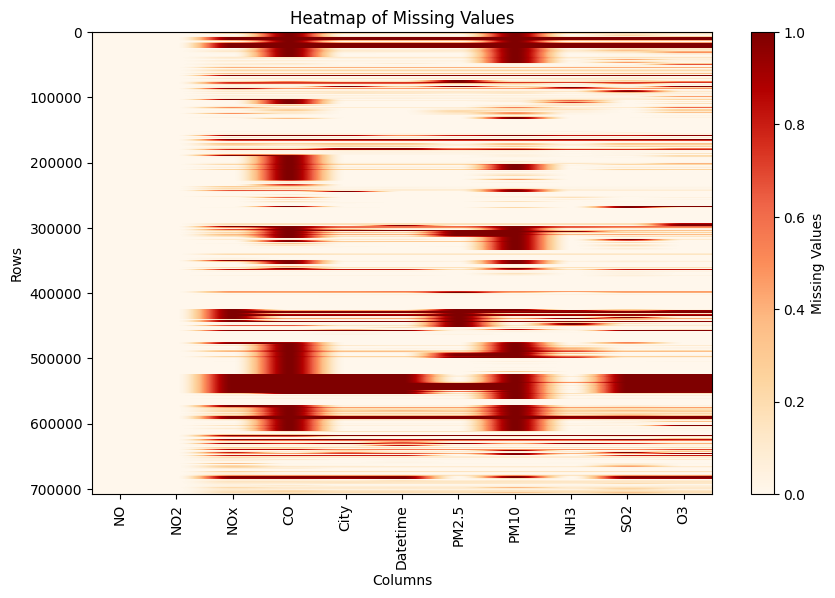

In [ ]:
# Function to create heatmap of missing values
def plot_missing_values_heatmap(rdd):
    # Collect RDD to the driver node
    data = rdd.collect()

    # Extract column names
    columns = rdd.flatMap(lambda row: row.asDict().keys()).distinct().collect()

    # Initialize a 2D list to store missing values
    missing_values_matrix = []

    # Iterate over each row to create the missing values matrix
    for row in data:
        missing_values_matrix.append([1 if cell is None else 0 for cell in row])

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(missing_values_matrix, cmap='OrRd', aspect='auto')
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Heatmap of Missing Values')
    plt.colorbar().set_label('Missing Values')
    plt.show()

# Call the function to plot the heatmap
plot_missing_values_heatmap(rdd)


**Interpretation**



*   From the above heatmep, we can say that many missing values are present in the dataset.
*  We cannot remove the missing rows from the dataset as we will miss on timestamps.













**Interpretations**

*  We cannot impute the missing values with group by datetime and its average, because dataset has missing values for continuous 3-4 days.
*   We will first convert Datetime variable into datetime data type.









In [ ]:
df.dtypes

[('City', 'string'),
 ('Datetime', 'timestamp'),
 ('PM2.5', 'double'),
 ('PM10', 'double'),
 ('NO', 'double'),
 ('NO2', 'double'),
 ('NOx', 'double'),
 ('NH3', 'double'),
 ('CO', 'double'),
 ('SO2', 'double'),
 ('O3', 'double')]

In [ ]:
from pyspark.sql.functions import to_timestamp, col

df = df.withColumn("Datetime", to_timestamp(col("Datetime"), 'MM/dd/yyyy HH:mm'))
df.show()

+---------+-------------------+-----+----+----+-----+-----+----+----+------+------+
|     City|           Datetime|PM2.5|PM10|  NO|  NO2|  NOx| NH3|  CO|   SO2|    O3|
+---------+-------------------+-----+----+----+-----+-----+----+----+------+------+
|Ahmedabad|2015-01-01 01:00:00| NULL|NULL| 1.0|40.01|36.37|NULL| 1.0|122.07|  NULL|
|Ahmedabad|2015-01-01 02:00:00| NULL|NULL|0.02|27.75|19.73|NULL|0.02|  85.9|  NULL|
|Ahmedabad|2015-01-01 03:00:00| NULL|NULL|0.08|19.32|11.08|NULL|0.08| 52.83|  NULL|
|Ahmedabad|2015-01-01 04:00:00| NULL|NULL| 0.3|16.45|  9.2|NULL| 0.3| 39.53|153.58|
|Ahmedabad|2015-01-01 05:00:00| NULL|NULL|0.12| 14.9| 7.85|NULL|0.12| 32.63|  NULL|
|Ahmedabad|2015-01-01 06:00:00| NULL|NULL|0.33|15.95|10.82|NULL|0.33| 29.87| 64.25|
|Ahmedabad|2015-01-01 07:00:00| NULL|NULL|0.45|15.94|12.47|NULL|0.45| 27.41|191.96|
|Ahmedabad|2015-01-01 08:00:00| NULL|NULL|1.03|16.66|16.48|NULL|1.03| 20.92|177.21|
|Ahmedabad|2015-01-01 09:00:00| NULL|NULL|1.47|16.25|18.02|NULL|1.47| 16.45|


*   Datetime variable is changed into datetime datatype.




In [ ]:
df = df.withColumnRenamed("PM2.5", "PM25")
# Show the resulting DataFrame
df.show()

+---------+-------------------+----+----+----+-----+-----+----+----+------+------+
|     City|           Datetime|PM25|PM10|  NO|  NO2|  NOx| NH3|  CO|   SO2|    O3|
+---------+-------------------+----+----+----+-----+-----+----+----+------+------+
|Ahmedabad|2015-01-01 01:00:00|NULL|NULL| 1.0|40.01|36.37|NULL| 1.0|122.07|  NULL|
|Ahmedabad|2015-01-01 02:00:00|NULL|NULL|0.02|27.75|19.73|NULL|0.02|  85.9|  NULL|
|Ahmedabad|2015-01-01 03:00:00|NULL|NULL|0.08|19.32|11.08|NULL|0.08| 52.83|  NULL|
|Ahmedabad|2015-01-01 04:00:00|NULL|NULL| 0.3|16.45|  9.2|NULL| 0.3| 39.53|153.58|
|Ahmedabad|2015-01-01 05:00:00|NULL|NULL|0.12| 14.9| 7.85|NULL|0.12| 32.63|  NULL|
|Ahmedabad|2015-01-01 06:00:00|NULL|NULL|0.33|15.95|10.82|NULL|0.33| 29.87| 64.25|
|Ahmedabad|2015-01-01 07:00:00|NULL|NULL|0.45|15.94|12.47|NULL|0.45| 27.41|191.96|
|Ahmedabad|2015-01-01 08:00:00|NULL|NULL|1.03|16.66|16.48|NULL|1.03| 20.92|177.21|
|Ahmedabad|2015-01-01 09:00:00|NULL|NULL|1.47|16.25|18.02|NULL|1.47| 16.45|122.08|
|Ahm

In [ ]:
def drop_null_columns(df):
    """
    This function drops columns containing all null values.
    :param df: A PySpark DataFrame
    """
    # Calculate the count of null values for each column
    null_counts = df.agg(*[sqlf.sum(sqlf.when(sqlf.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
    # Collect the counts into a dictionary
    null_counts_dict = null_counts.collect()[0].asDict()
    # Identify columns with all null values
    to_drop = [col for col, count in null_counts_dict.items() if count == df.count()]
    # Drop identified columns
    df = df.drop(*to_drop)

    return df

# Example usage
df = drop_null_columns(df)
df.show()

+---------+-------------------+----+----+----+-----+-----+----+----+------+------+
|     City|           Datetime|PM25|PM10|  NO|  NO2|  NOx| NH3|  CO|   SO2|    O3|
+---------+-------------------+----+----+----+-----+-----+----+----+------+------+
|Ahmedabad|2015-01-01 01:00:00|NULL|NULL| 1.0|40.01|36.37|NULL| 1.0|122.07|  NULL|
|Ahmedabad|2015-01-01 02:00:00|NULL|NULL|0.02|27.75|19.73|NULL|0.02|  85.9|  NULL|
|Ahmedabad|2015-01-01 03:00:00|NULL|NULL|0.08|19.32|11.08|NULL|0.08| 52.83|  NULL|
|Ahmedabad|2015-01-01 04:00:00|NULL|NULL| 0.3|16.45|  9.2|NULL| 0.3| 39.53|153.58|
|Ahmedabad|2015-01-01 05:00:00|NULL|NULL|0.12| 14.9| 7.85|NULL|0.12| 32.63|  NULL|
|Ahmedabad|2015-01-01 06:00:00|NULL|NULL|0.33|15.95|10.82|NULL|0.33| 29.87| 64.25|
|Ahmedabad|2015-01-01 07:00:00|NULL|NULL|0.45|15.94|12.47|NULL|0.45| 27.41|191.96|
|Ahmedabad|2015-01-01 08:00:00|NULL|NULL|1.03|16.66|16.48|NULL|1.03| 20.92|177.21|
|Ahmedabad|2015-01-01 09:00:00|NULL|NULL|1.47|16.25|18.02|NULL|1.47| 16.45|122.08|
|Ahm

In [ ]:
rdd = df.rdd
print(rdd.take(5))

[Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 1, 0), PM25=None, PM10=None, NO=1.0, NO2=40.01, NOx=36.37, NH3=None, CO=1.0, SO2=122.07, O3=None), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 2, 0), PM25=None, PM10=None, NO=0.02, NO2=27.75, NOx=19.73, NH3=None, CO=0.02, SO2=85.9, O3=None), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 3, 0), PM25=None, PM10=None, NO=0.08, NO2=19.32, NOx=11.08, NH3=None, CO=0.08, SO2=52.83, O3=None), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 4, 0), PM25=None, PM10=None, NO=0.3, NO2=16.45, NOx=9.2, NH3=None, CO=0.3, SO2=39.53, O3=153.58), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 5, 0), PM25=None, PM10=None, NO=0.12, NO2=14.9, NOx=7.85, NH3=None, CO=0.12, SO2=32.63, O3=None)]


**Interpretations**

* Still missing values are present in the data, now we can not fill it by average of year, if we fill the value by average of year the data integrity will be changed, so we concidered that value of the pollutants are same throughout the month. So we can use the backward or forward fill technique for imputing the missing values.





In [ ]:
df["DateTime"].dtype

Column<'DateTime[dtype]'>

In [ ]:
def backward_fill(df):
    # Get the column names and their data types
    schema = df.schema

    # Iterate over each column and backward fill missing values, skipping date and string types
    for field in schema.fields:
        column = field.name
        data_type = field.dataType

        # Skip date and string columns
        if isinstance(data_type, TimestampType) or isinstance(data_type, StringType):
            continue

        last_valid_value = df.select(last(col(column), ignorenulls=True)).collect()[0][0]
        df = df.fillna(last_valid_value, subset=[column])

    return df

# Backward fill missing values
df_filled = backward_fill(df)
df_filled.show()

+---------+-------------------+----+----+----+-----+-----+---+----+------+------+
|     City|           Datetime|PM25|PM10|  NO|  NO2|  NOx|NH3|  CO|   SO2|    O3|
+---------+-------------------+----+----+----+-----+-----+---+----+------+------+
|Ahmedabad|2015-01-01 01:00:00|15.0|66.0| 1.0|40.01|36.37|5.2| 1.0|122.07| 17.05|
|Ahmedabad|2015-01-01 02:00:00|15.0|66.0|0.02|27.75|19.73|5.2|0.02|  85.9| 17.05|
|Ahmedabad|2015-01-01 03:00:00|15.0|66.0|0.08|19.32|11.08|5.2|0.08| 52.83| 17.05|
|Ahmedabad|2015-01-01 04:00:00|15.0|66.0| 0.3|16.45|  9.2|5.2| 0.3| 39.53|153.58|
|Ahmedabad|2015-01-01 05:00:00|15.0|66.0|0.12| 14.9| 7.85|5.2|0.12| 32.63| 17.05|
|Ahmedabad|2015-01-01 06:00:00|15.0|66.0|0.33|15.95|10.82|5.2|0.33| 29.87| 64.25|
|Ahmedabad|2015-01-01 07:00:00|15.0|66.0|0.45|15.94|12.47|5.2|0.45| 27.41|191.96|
|Ahmedabad|2015-01-01 08:00:00|15.0|66.0|1.03|16.66|16.48|5.2|1.03| 20.92|177.21|
|Ahmedabad|2015-01-01 09:00:00|15.0|66.0|1.47|16.25|18.02|5.2|1.47| 16.45|122.08|
|Ahmedabad|2015-

In [ ]:
def forward_fill(df):
    # Get the column names and their data types
    schema = df.schema

    # Iterate over each column and forward fill missing values, skipping date and string types
    for field in schema.fields:
        column = field.name
        data_type = field.dataType

        # Skip date and string columns
        if isinstance(data_type, TimestampType) or isinstance(data_type, StringType):
            continue

        first_valid_value = df.select(first(col(column), ignorenulls=True)).collect()[0][0]
        df = df.fillna(first_valid_value, subset=[column])

    return df

# Forward fill missing values
df_filled = forward_fill(df_filled)
df_filled.show()

+---------+-------------------+----+----+----+-----+-----+---+----+------+------+
|     City|           Datetime|PM25|PM10|  NO|  NO2|  NOx|NH3|  CO|   SO2|    O3|
+---------+-------------------+----+----+----+-----+-----+---+----+------+------+
|Ahmedabad|2015-01-01 01:00:00|15.0|66.0| 1.0|40.01|36.37|5.2| 1.0|122.07| 17.05|
|Ahmedabad|2015-01-01 02:00:00|15.0|66.0|0.02|27.75|19.73|5.2|0.02|  85.9| 17.05|
|Ahmedabad|2015-01-01 03:00:00|15.0|66.0|0.08|19.32|11.08|5.2|0.08| 52.83| 17.05|
|Ahmedabad|2015-01-01 04:00:00|15.0|66.0| 0.3|16.45|  9.2|5.2| 0.3| 39.53|153.58|
|Ahmedabad|2015-01-01 05:00:00|15.0|66.0|0.12| 14.9| 7.85|5.2|0.12| 32.63| 17.05|
|Ahmedabad|2015-01-01 06:00:00|15.0|66.0|0.33|15.95|10.82|5.2|0.33| 29.87| 64.25|
|Ahmedabad|2015-01-01 07:00:00|15.0|66.0|0.45|15.94|12.47|5.2|0.45| 27.41|191.96|
|Ahmedabad|2015-01-01 08:00:00|15.0|66.0|1.03|16.66|16.48|5.2|1.03| 20.92|177.21|
|Ahmedabad|2015-01-01 09:00:00|15.0|66.0|1.47|16.25|18.02|5.2|1.47| 16.45|122.08|
|Ahmedabad|2015-

In [ ]:
rdd_filled = df_filled.rdd
print(rdd_filled.take(5))

[Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 1, 0), PM25=15.0, PM10=66.0, NO=1.0, NO2=40.01, NOx=36.37, NH3=5.2, CO=1.0, SO2=122.07, O3=17.05), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 2, 0), PM25=15.0, PM10=66.0, NO=0.02, NO2=27.75, NOx=19.73, NH3=5.2, CO=0.02, SO2=85.9, O3=17.05), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 3, 0), PM25=15.0, PM10=66.0, NO=0.08, NO2=19.32, NOx=11.08, NH3=5.2, CO=0.08, SO2=52.83, O3=17.05), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 4, 0), PM25=15.0, PM10=66.0, NO=0.3, NO2=16.45, NOx=9.2, NH3=5.2, CO=0.3, SO2=39.53, O3=153.58), Row(City='Ahmedabad', Datetime=datetime.datetime(2015, 1, 1, 5, 0), PM25=15.0, PM10=66.0, NO=0.12, NO2=14.9, NOx=7.85, NH3=5.2, CO=0.12, SO2=32.63, O3=17.05)]


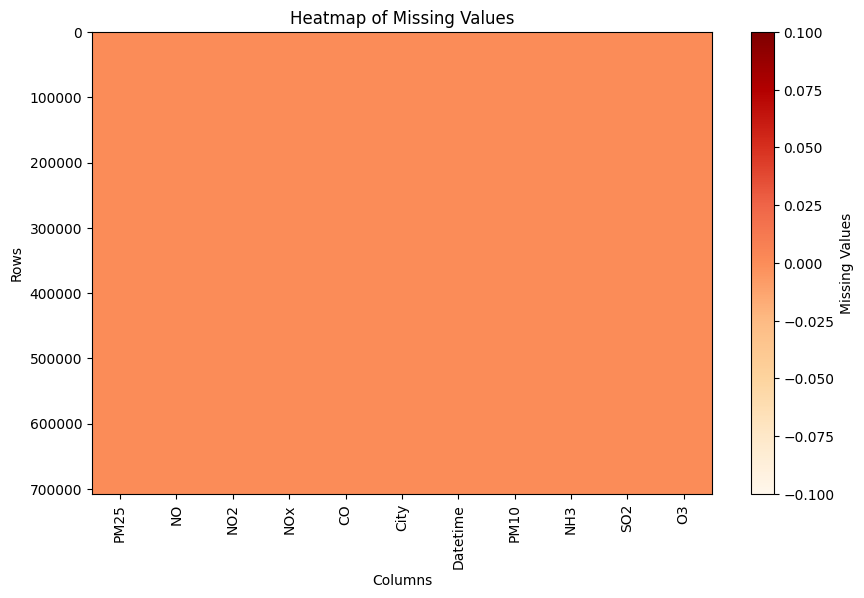

In [ ]:
# Function to create heatmap of missing values
def plot_missing_values_heatmap(rdd_filled):
    # Collect RDD to the driver node
    data = rdd_filled.collect()

    # Extract column names
    columns = rdd_filled.flatMap(lambda row: row.asDict().keys()).distinct().collect()

    # Initialize a 2D list to store missing values
    missing_values_matrix = []

    # Iterate over each row to create the missing values matrix
    for row in data:
        missing_values_matrix.append([1 if cell is None else 0 for cell in row])

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(missing_values_matrix, cmap='OrRd', aspect='auto')
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Heatmap of Missing Values')
    plt.colorbar().set_label('Missing Values')
    plt.show()

# Call the function to plot the heatmap
plot_missing_values_heatmap(rdd_filled)


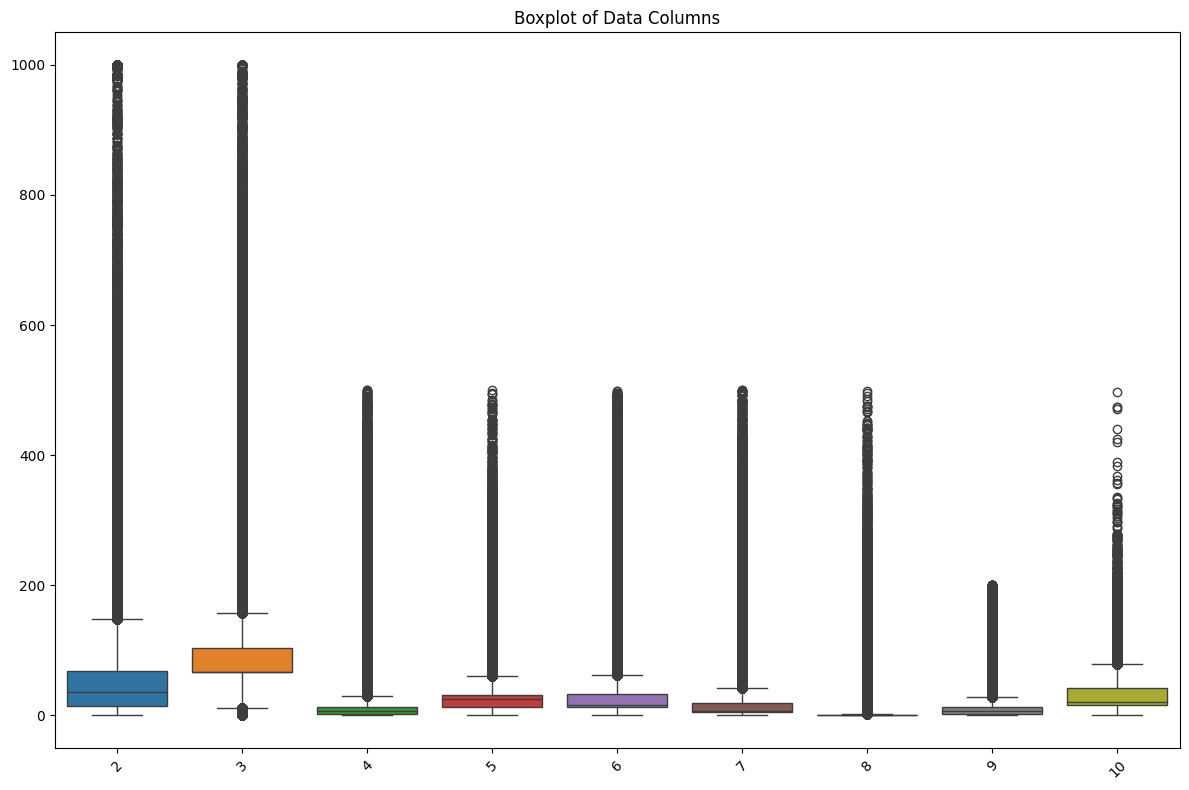

In [ ]:
# Convert RDD to DataFrame
df = spark.createDataFrame(rdd_filled)
# Extract column names
columns = df.columns

# Convert each column in the DataFrame to an RDD of values
rdd_columns = [df.select(col).rdd.flatMap(lambda x: x).collect() for col in columns]

# Plot boxplots for each column
plt.figure(figsize=(12, 8))
sns.boxplot(data=rdd_columns)
plt.title("Boxplot of Data Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**

* From the box plot, can say that the outliers are present in the data, but this is the time series data
* So we can not remove outliers, if we do this the continuity will not remain for the data.

# **Visualization**

## Standadize data

In [ ]:
df_filled.createOrReplaceTempView("pollution_data")

# Calculate mean and standard deviation for each pollutant
pollutants = ['PM25', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
stats = spark.sql("""
SELECT
    AVG(PM25) as mean_PM25, STDDEV(PM25) as stddev_PM25,
    AVG(PM10) as mean_PM10, STDDEV(PM10) as stddev_PM10,
    AVG(NO) as mean_NO, STDDEV(NO) as stddev_NO,
    AVG(NO2) as mean_NO2, STDDEV(NO2) as stddev_NO2,
    AVG(NOX) as mean_NOx, STDDEV(NOX) as stddev_NOx,
    AVG(NH3) as mean_NH3, STDDEV(NH3) as stddev_NH3,
    AVG(CO) as mean_CO, STDDEV(CO) as stddev_CO,
    AVG(SO2) as mean_SO2, STDDEV(SO2) as stddev_SO2,
    AVG(O3) as mean_O3, STDDEV(O3) as stddev_O3
FROM pollution_data
""").collect()[0]

# Create a new DataFrame with standardized values
standardized_df = spark.sql(f"""
SELECT
    City, Datetime,
    ((PM25 - {stats['mean_PM25']}) / {stats['stddev_PM25']}) as PM25,
    ((PM10 - {stats['mean_PM10']}) / {stats['stddev_PM10']}) as PM10,
    ((NO - {stats['mean_NO']}) / {stats['stddev_NO']}) as NO,
    ((NO2 - {stats['mean_NO2']}) / {stats['stddev_NO2']}) as NO2,
    ((NOX - {stats['mean_NOx']}) / {stats['stddev_NOx']}) as NOx,
    ((NH3 - {stats['mean_NH3']}) / {stats['stddev_NH3']}) as NH3,
    ((CO - {stats['mean_CO']}) / {stats['stddev_CO']}) as CO,
    ((SO2 - {stats['mean_SO2']}) / {stats['stddev_SO2']}) as SO2,
    ((O3 - {stats['mean_O3']}) / {stats['stddev_O3']}) as O3
FROM pollution_data
""")

standardized_df.show()

+---------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+
|     City|           Datetime|               PM25|               PM10|                  NO|                 NO2|                 NOx|                NH3|                  CO|                 SO2|                 O3|
+---------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+
|Ahmedabad|2015-01-01 01:00:00|-0.5982093657603365|-0.3685806781123498| -0.4538428066660982|  0.4300554269518306| 0.19727602311170278|-0.4654885908159442| -0.0960768907904475|  6.1100135850461745|-0.5217733330573117|
|Ahmedabad|2015-01-01 02:00:00|-0.5982093657603365|-0.3685806781123498| -0.4865049001712003|-0.02995824255413214| -0.255059988579454

In [ ]:
standardized_df = standardized_df.orderBy("Datetime")

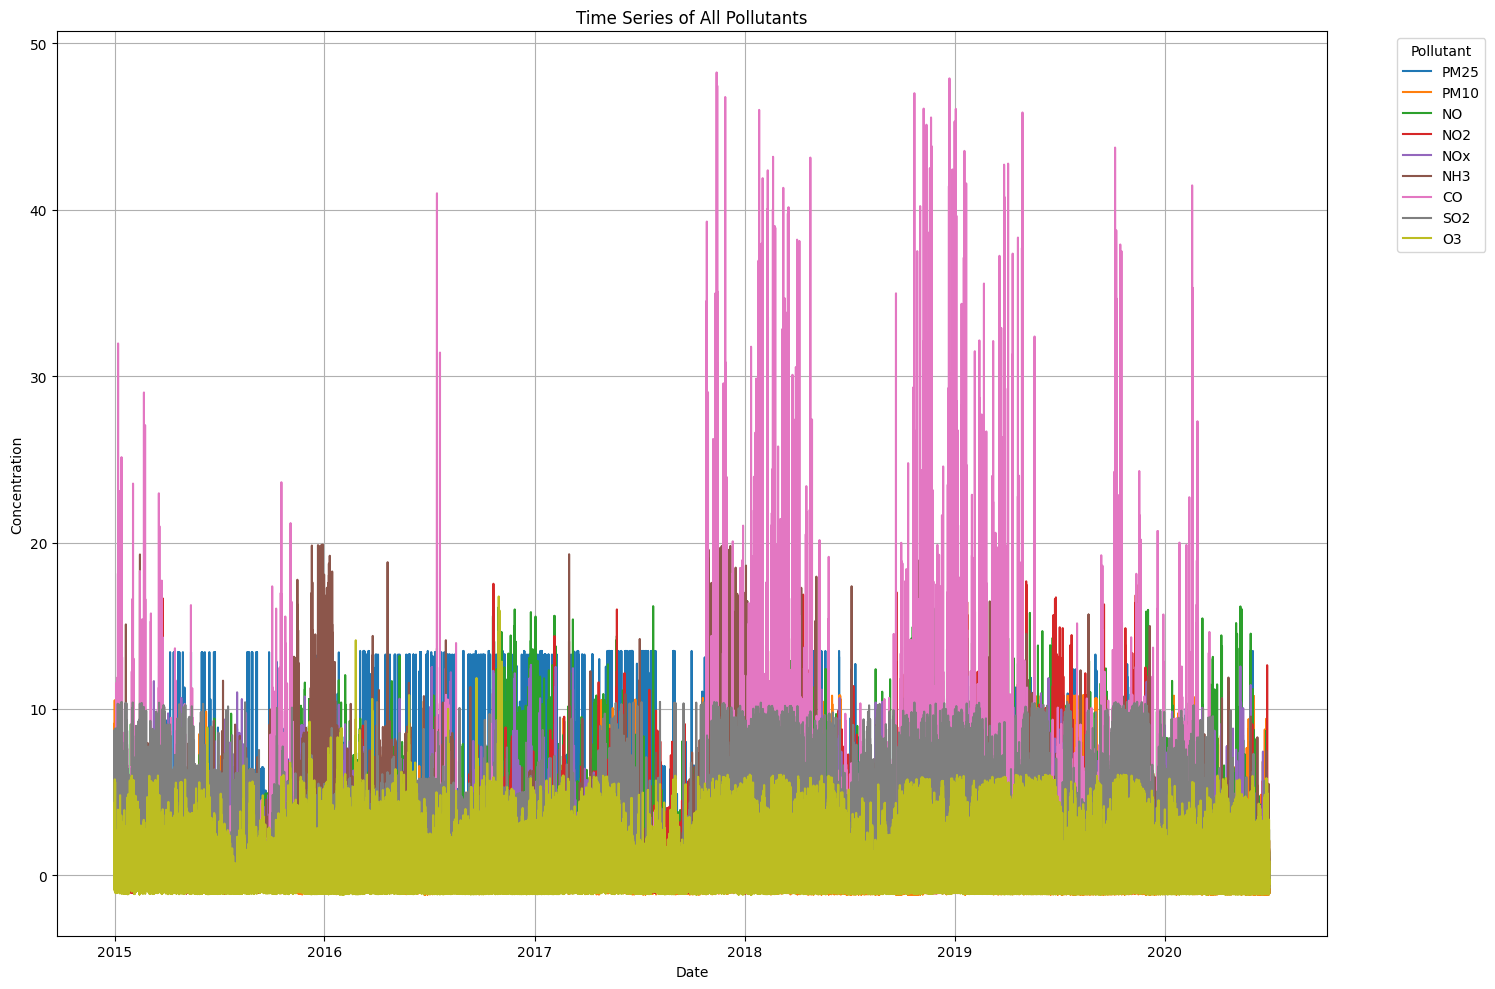

In [ ]:
standardized_df = standardized_df.withColumn('Datetime', F.to_timestamp('Datetime'))

data = standardized_df.select('Datetime', 'PM25','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3').collect()

dates = [row['Datetime'] for row in data]
pollutants = {'PM25': [], 'PM10': [], 'NO': [], 'NO2': [], 'NOx': [], 'NH3': [], 'CO': [], 'SO2': [], 'O3': []}

for row in data:
    for pollutant in pollutants.keys():
        pollutants[pollutant].append(row[pollutant])

# Plotting
plt.figure(figsize=(15, 10))
for pollutant, values in pollutants.items():
    plt.plot(dates, values, label=pollutant)

plt.title('Time Series of All Pollutants')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend(title='Pollutant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

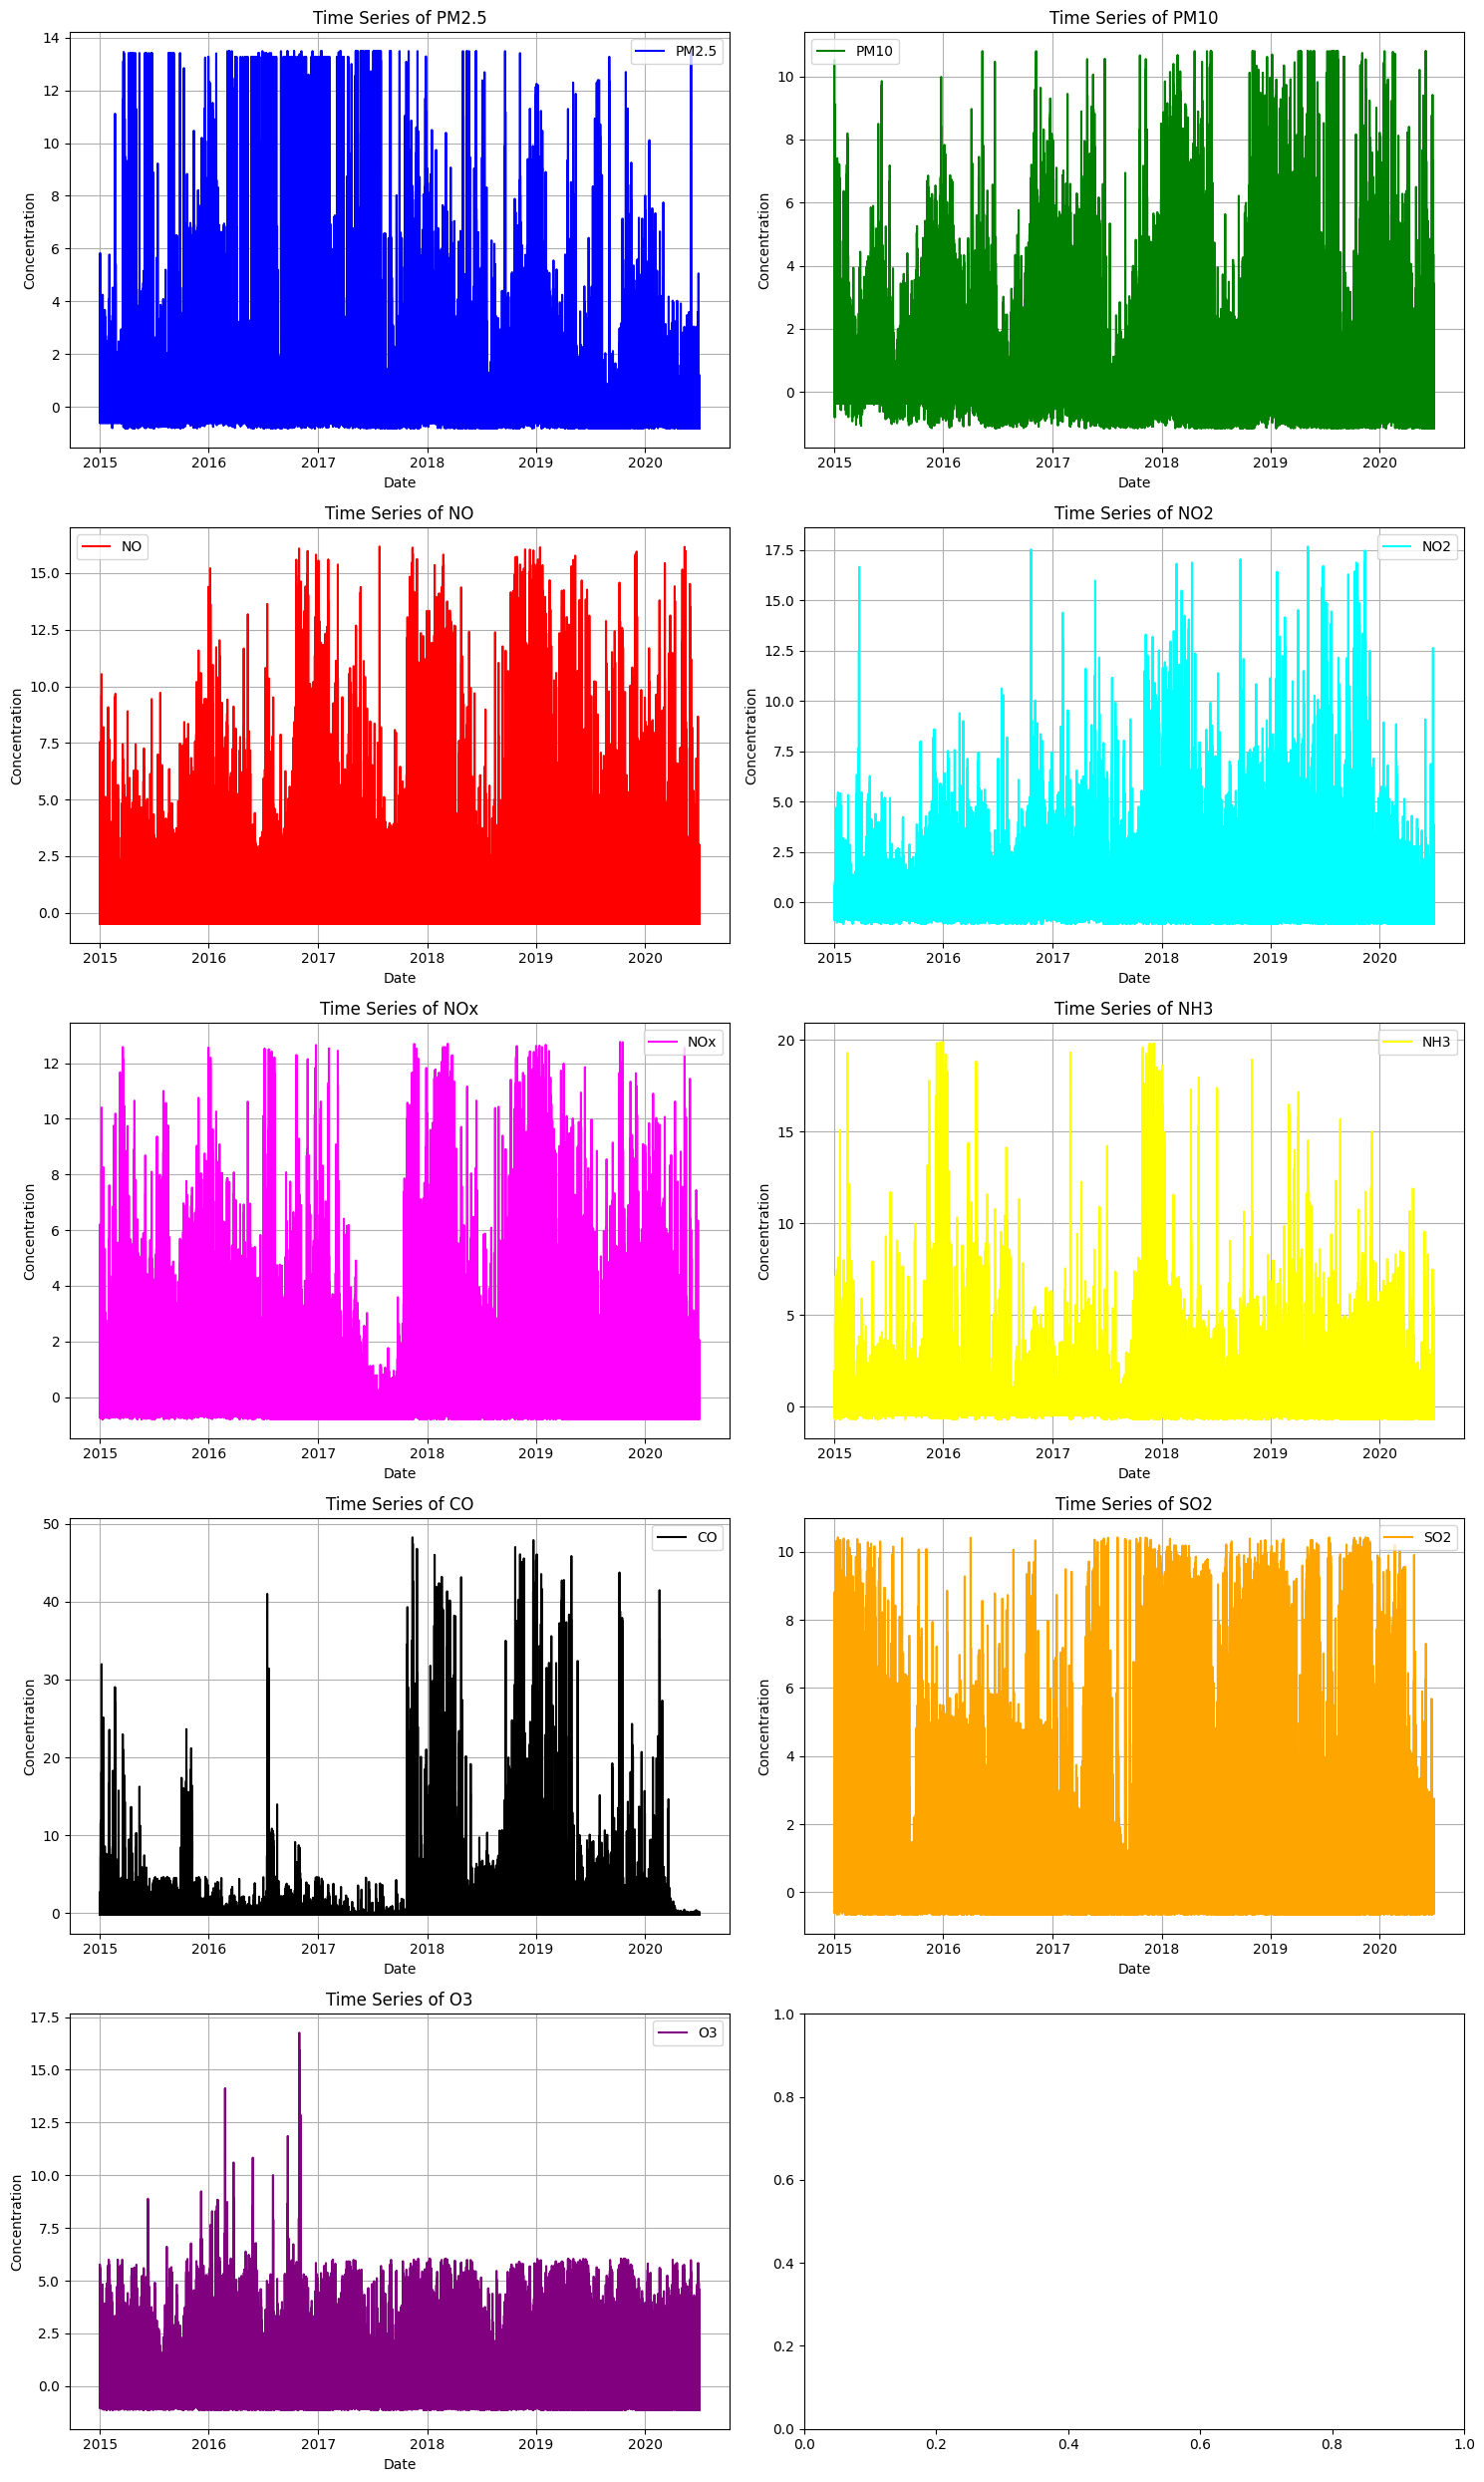

In [ ]:
data = standardized_df.select('Datetime', 'PM25', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3').collect()

dates = [row['Datetime'] for row in data]
pollutants = {
    'PM2.5': [row['PM25'] for row in data],
    'PM10': [row['PM10'] for row in data],
    'NO': [row['NO'] for row in data],
    'NO2': [row['NO2'] for row in data],
    'NOx': [row['NOx'] for row in data],
    'NH3': [row['NH3'] for row in data],
    'CO': [row['CO'] for row in data],
    'SO2': [row['SO2'] for row in data],
    'O3': [row['O3'] for row in data]
}

colors = {
    'PM2.5': 'blue',
    'PM10': 'green',
    'NO': 'red',
    'NO2': 'cyan',
    'NOx': 'magenta',
    'NH3': 'yellow',
    'CO': 'black',
    'SO2': 'orange',
    'O3': 'purple'
}

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
axs = axs.flatten()

for i, (pollutant, values) in enumerate(pollutants.items()):
    axs[i].plot(dates, values, label=pollutant, color=colors[pollutant])
    axs[i].set_title(f'Time Series of {pollutant}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Concentration')
    axs[i].legend()
    axs[i].grid(True)


plt.tight_layout()
plt.show()

In [ ]:
standardized_df.createOrReplaceTempView("pollution_data")

# calculate total of each pollutant for each city
total_pollutants_sql = """
SELECT City,
       SUM(PM25) as Total_PM25,
       SUM(PM10) as Total_PM10,
       SUM(NO) as Total_NO,
       SUM(NO2) as Total_NO2,
       SUM(NOX) as Total_NOx,
       SUM(NH3) as Total_NH3,
       SUM(CO) as Total_CO,
       SUM(SO2) as Total_SO2,
       SUM(O3) as Total_O3
FROM pollution_data
GROUP BY City
"""

total_pollutants_df = spark.sql(total_pollutants_sql)

total_pollutants_df.show()

total_pollutants_df.createOrReplaceTempView("city_pollutant_totals")

+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|              City|         Total_PM25|         Total_PM10|           Total_NO|          Total_NO2|          Total_NOx|          Total_NH3|           Total_CO|          Total_SO2|           Total_O3|
+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|             Patna| 23514.763875332494|-13110.254608460033| 15794.548633357037|  11980.49409063566| 11506.954074082929|-18286.317409643692| -2640.079982189075| 17505.865396339454| 3114.0657906825845|
|           Chennai|   -6241.7686535433|-18040.503917681726| -9056.012570529234|-20730.807159611828|-15072.342764111607|  61724.36142039002| -4374.727829610953|-10985.432317226854|  541.1117312819

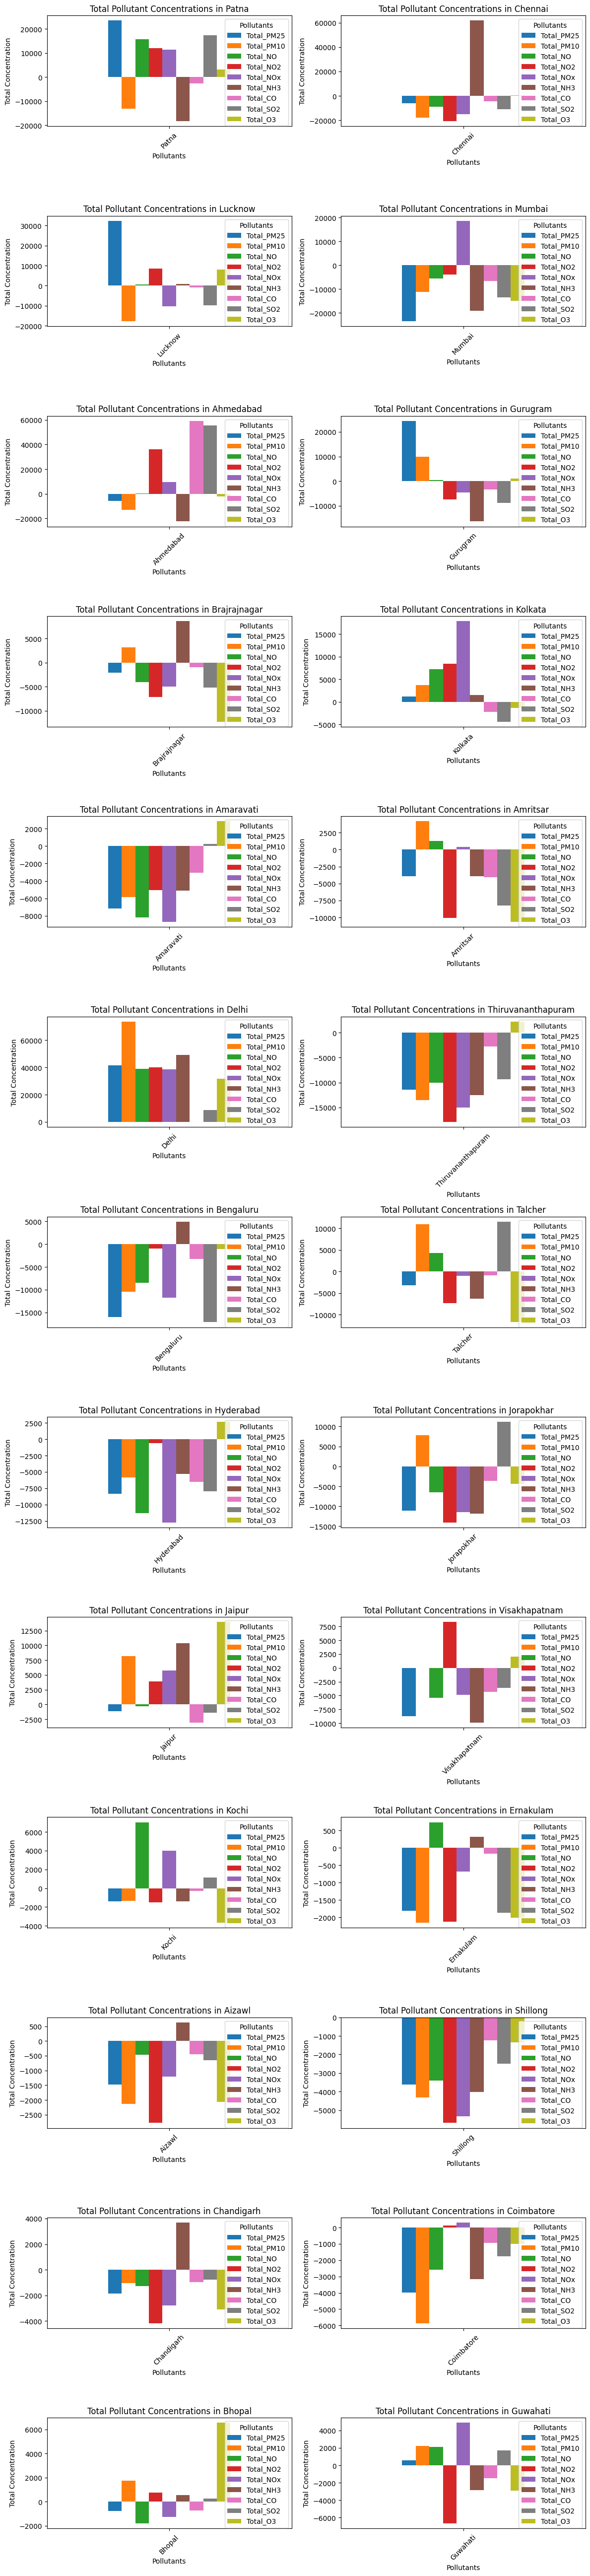

In [ ]:
import pandas as pd
plot_data = total_pollutants_df.collect()

pandas_df = pd.DataFrame(plot_data)
pandas_df.columns = ['City', 'Total_PM25', 'Total_PM10', 'Total_NO', 'Total_NO2', 'Total_NOx', 'Total_NH3', 'Total_CO', 'Total_SO2', 'Total_O3']

cities = pandas_df['City'].unique()
pollutants = ['Total_PM25', 'Total_PM10', 'Total_NO', 'Total_NO2', 'Total_NOx', 'Total_NH3', 'Total_CO', 'Total_SO2', 'Total_O3']

num_cities = len(cities)
fig, axes = plt.subplots(nrows=(num_cities // 2 + num_cities % 2), ncols=2, figsize=(12, 4 * (num_cities // 2 + num_cities % 2)))

axes = axes.flatten()

for index, city in enumerate(cities):
    city_data = pandas_df[pandas_df['City'] == city]
    city_data.set_index('City', inplace=True)
    city_data[pollutants].plot(kind='bar', ax=axes[index], title=f"Total Pollutant Concentrations in {city}")
    axes[index].set_ylabel('Total Concentration')
    axes[index].set_xlabel('Pollutants')
    axes[index].tick_params(axis='x', rotation=45)
    axes[index].legend(title='Pollutants')

plt.tight_layout()
plt.show()

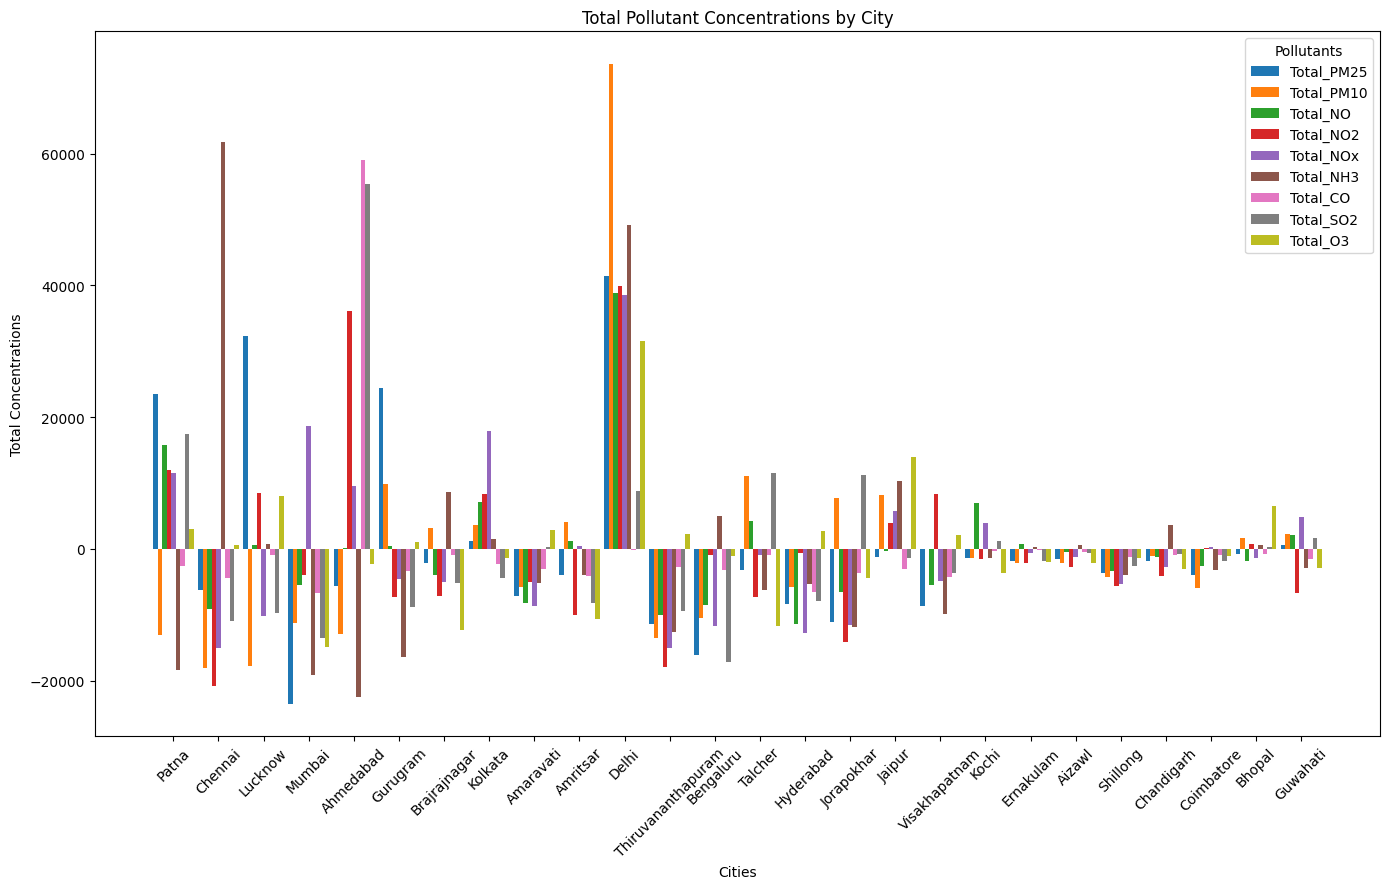

In [ ]:
total_pollutants_df = spark.sql("SELECT * FROM city_pollutant_totals")
plot_data = total_pollutants_df.collect()

pandas_df = pd.DataFrame(plot_data)
pandas_df.columns = ['City', 'Total_PM25', 'Total_PM10', 'Total_NO', 'Total_NO2', 'Total_NOx', 'Total_NH3', 'Total_CO', 'Total_SO2', 'Total_O3']

pandas_df.set_index('City', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

pollutants = ['Total_PM25', 'Total_PM10', 'Total_NO', 'Total_NO2', 'Total_NOx', 'Total_NH3', 'Total_CO', 'Total_SO2', 'Total_O3']
x = np.arange(len(pandas_df.index))
width = 0.1

for i, pollutant in enumerate(pollutants):
    ax.bar(x + i * width, pandas_df[pollutant], width, label=pollutant)

ax.set_xlabel('Cities')
ax.set_ylabel('Total Concentrations')
ax.set_title('Total Pollutant Concentrations by City')
ax.set_xticks(x + width * (len(pollutants)-1) / 2)
ax.set_xticklabels(pandas_df.index)
ax.legend(title="Pollutants")

fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

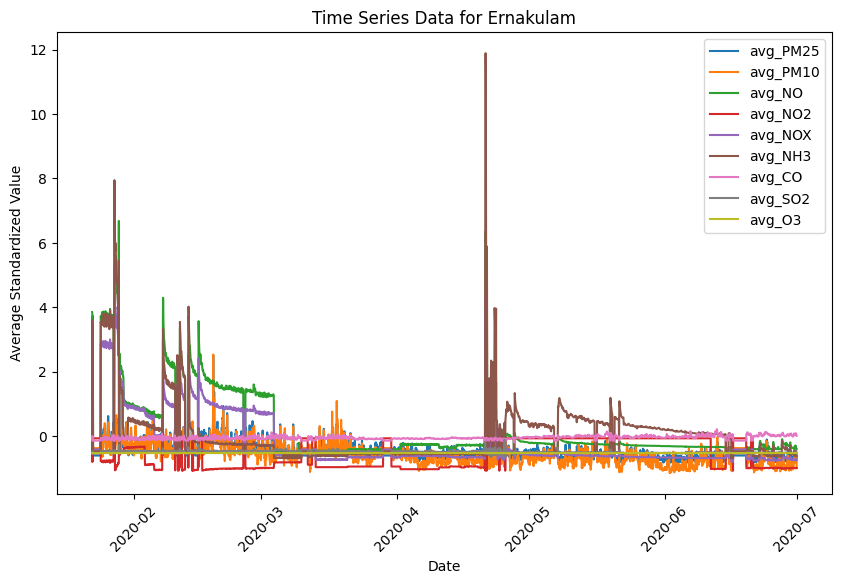

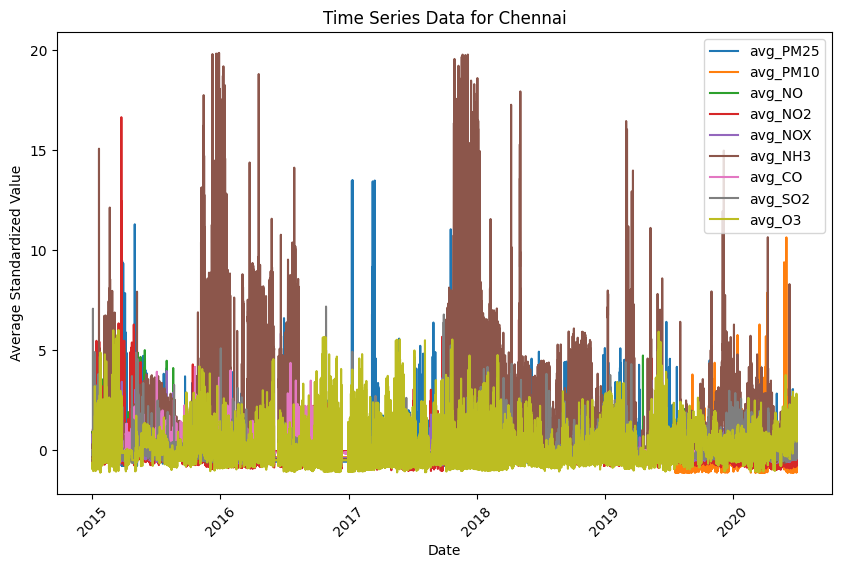

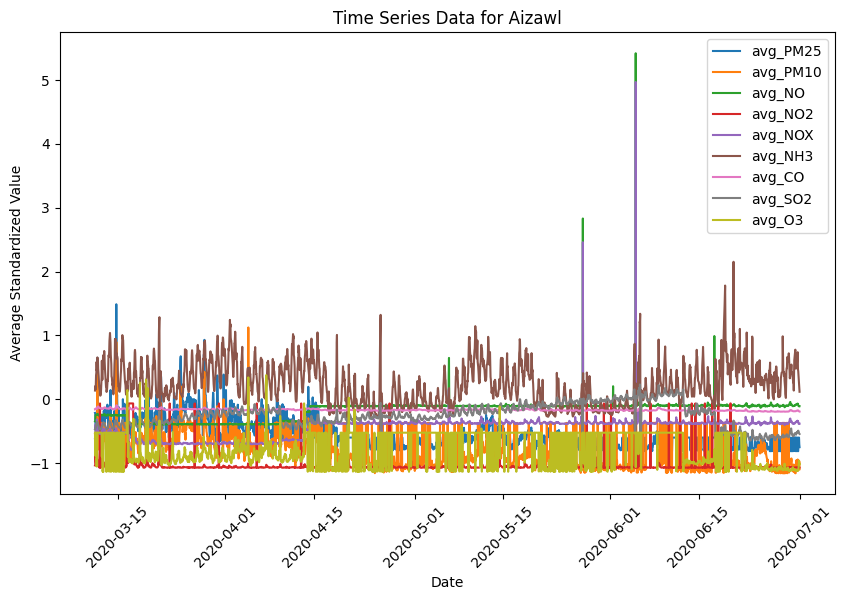

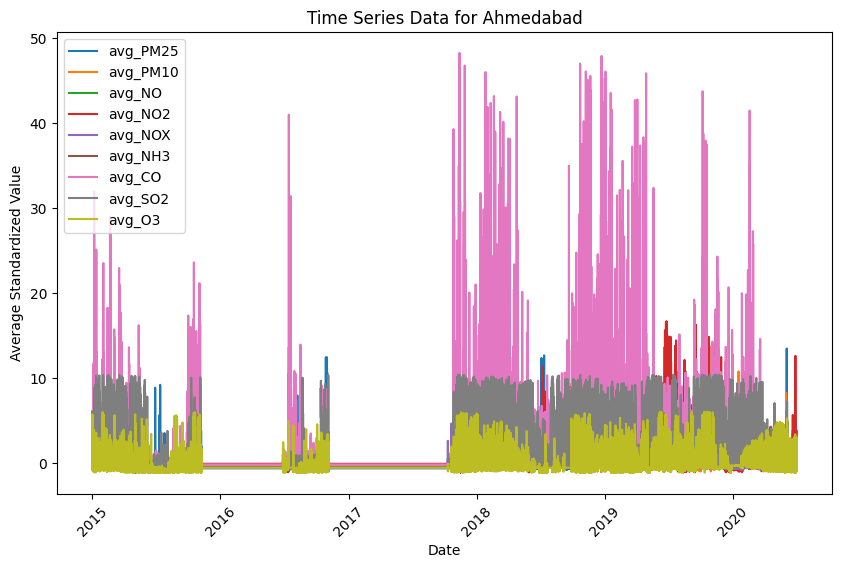

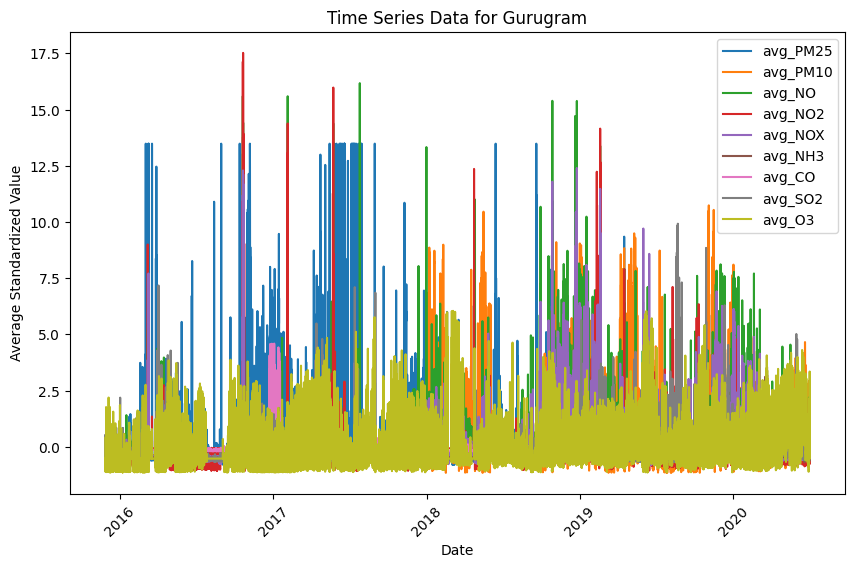

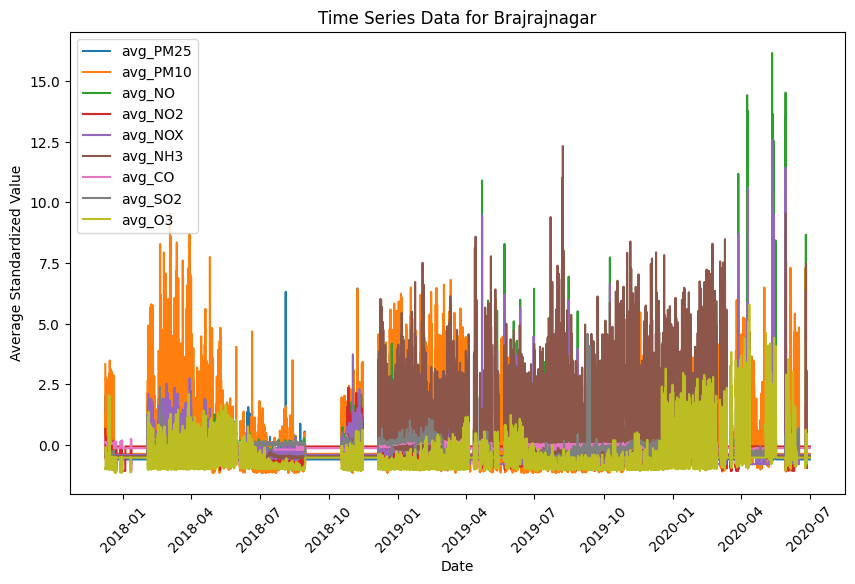

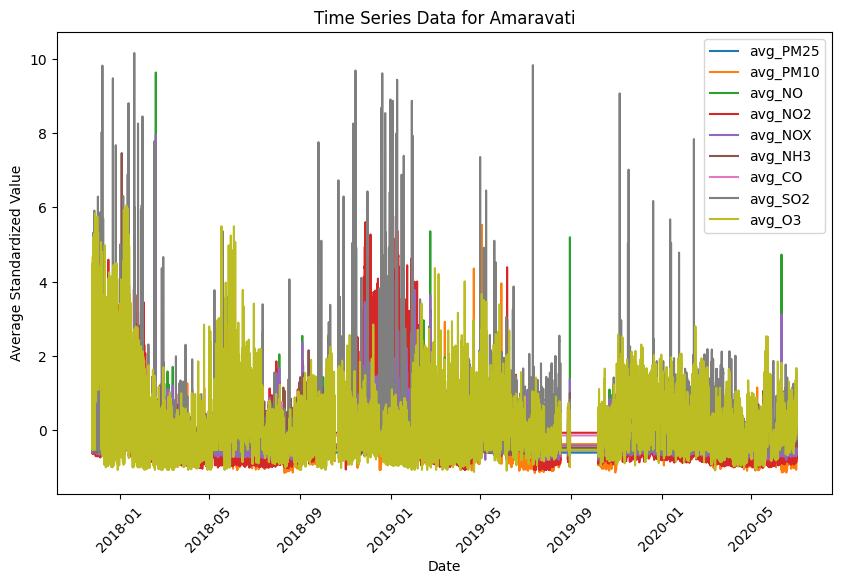

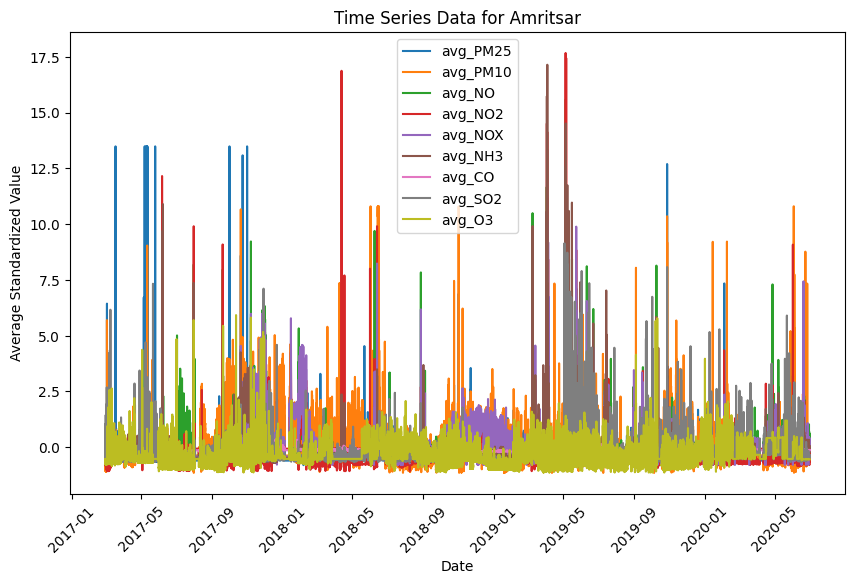

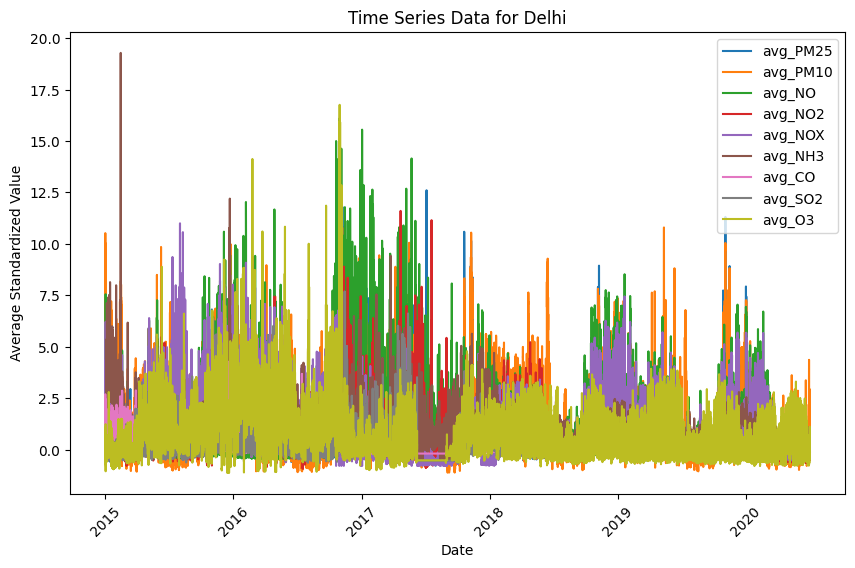

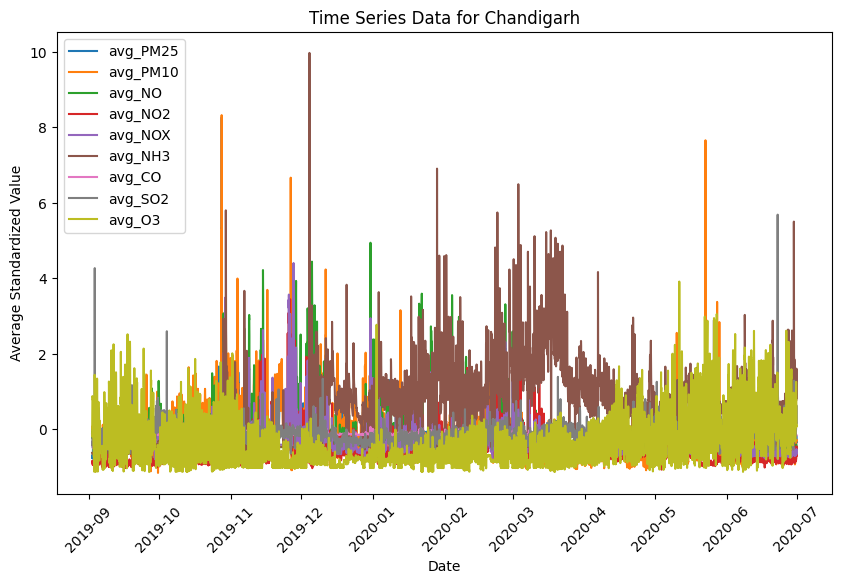

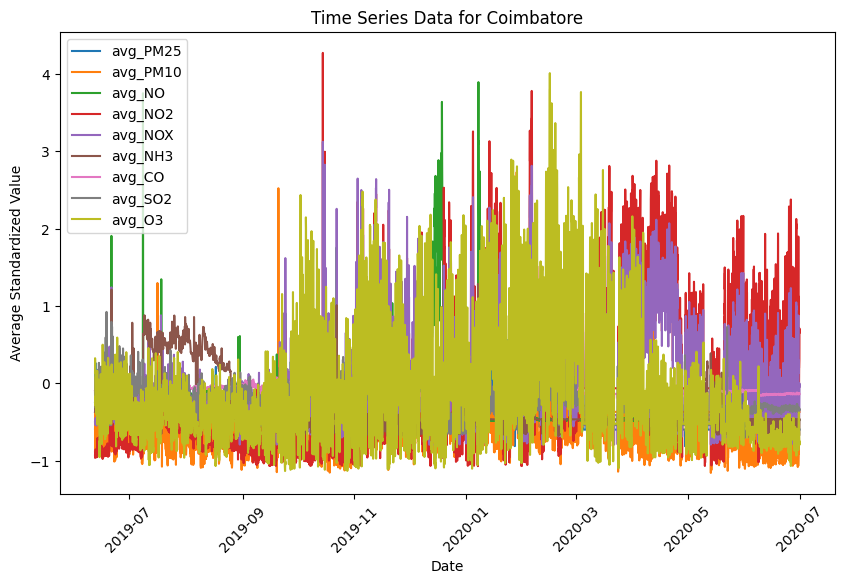

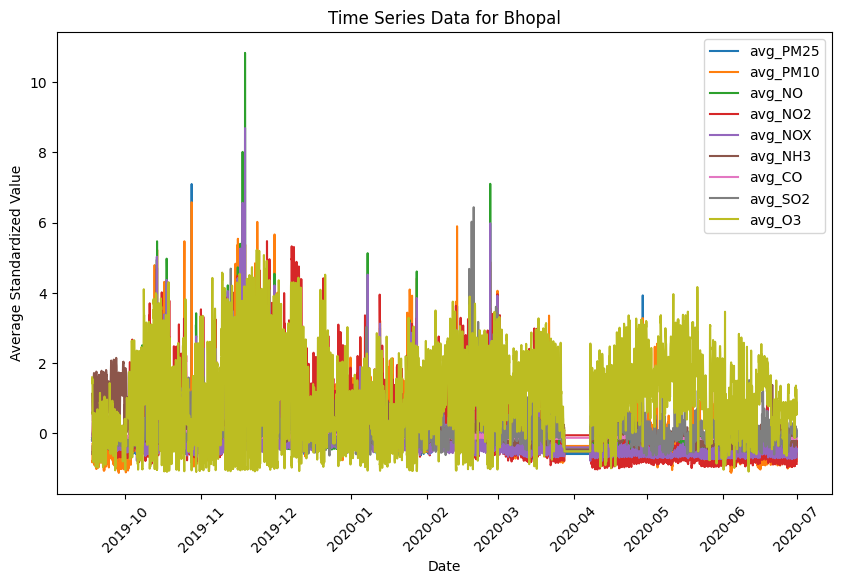

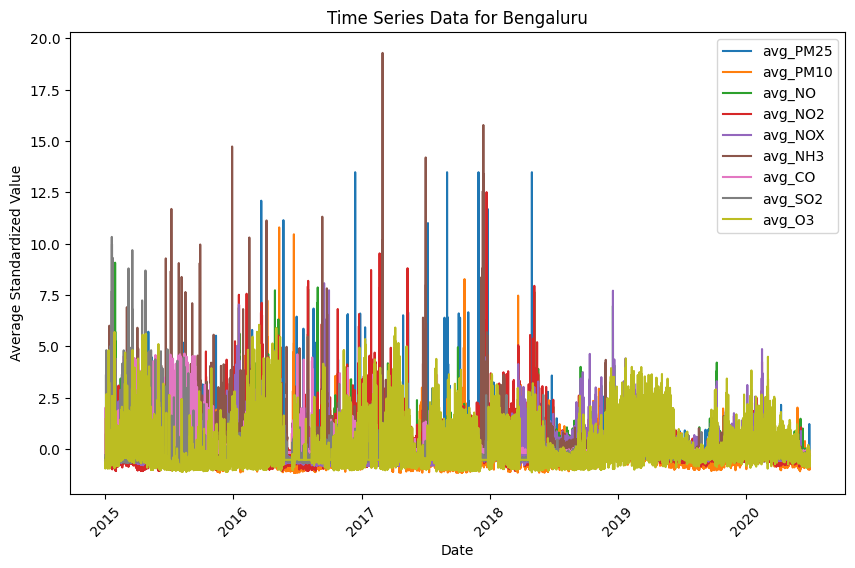

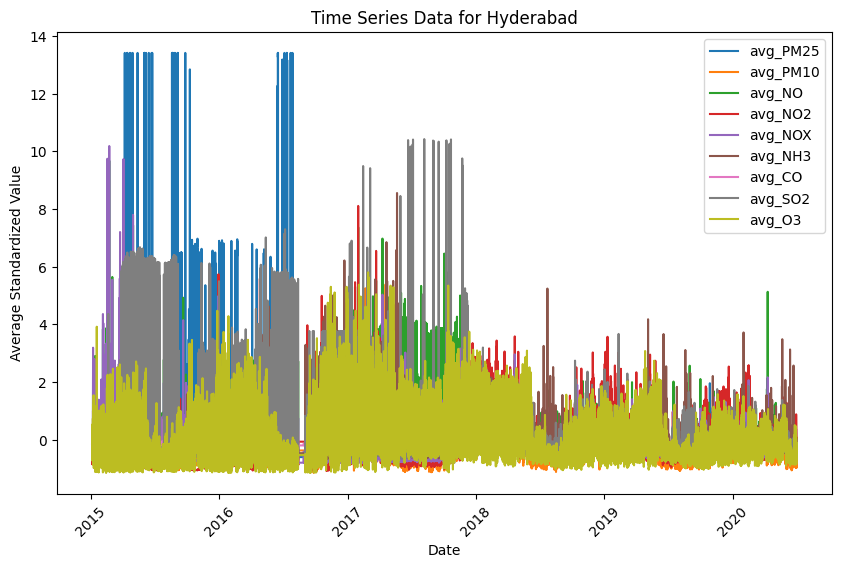

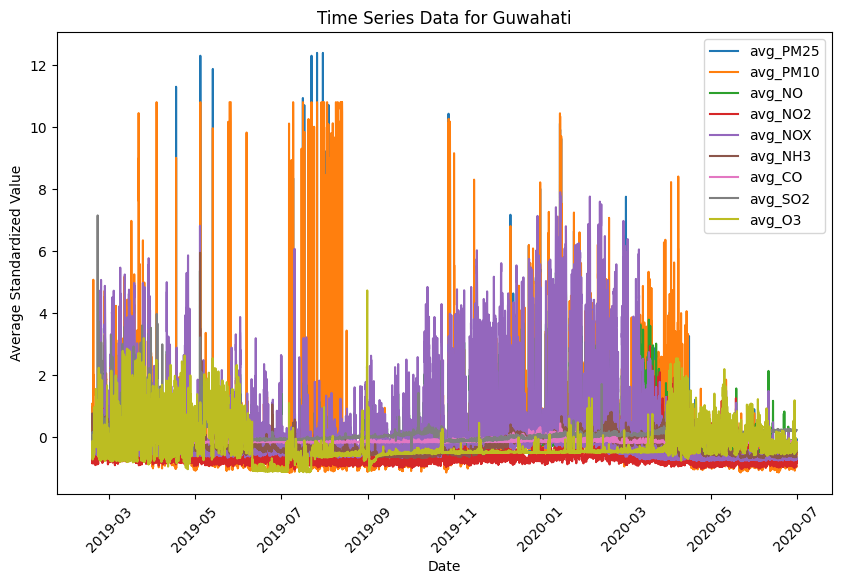

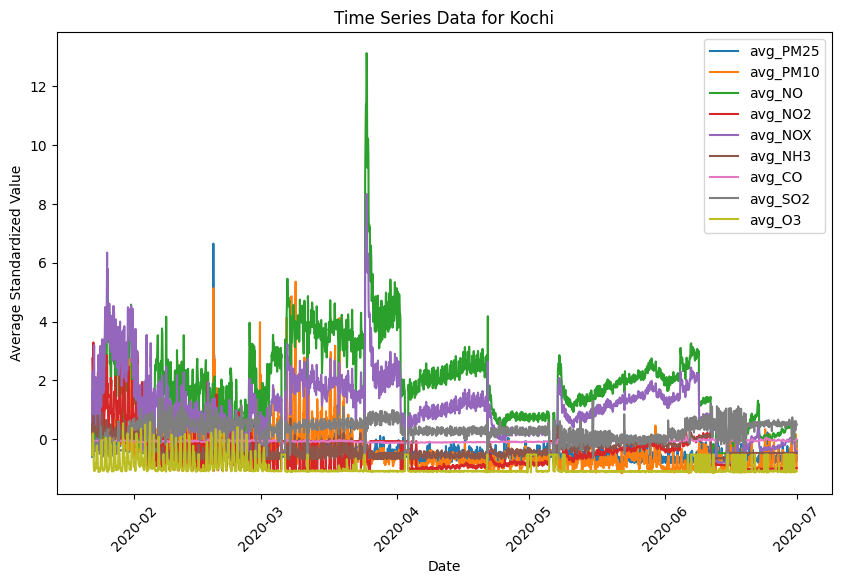

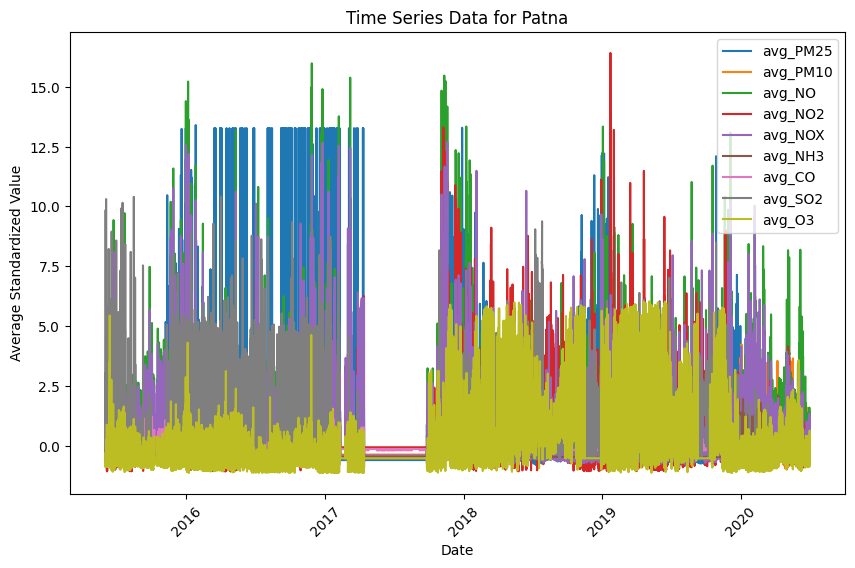

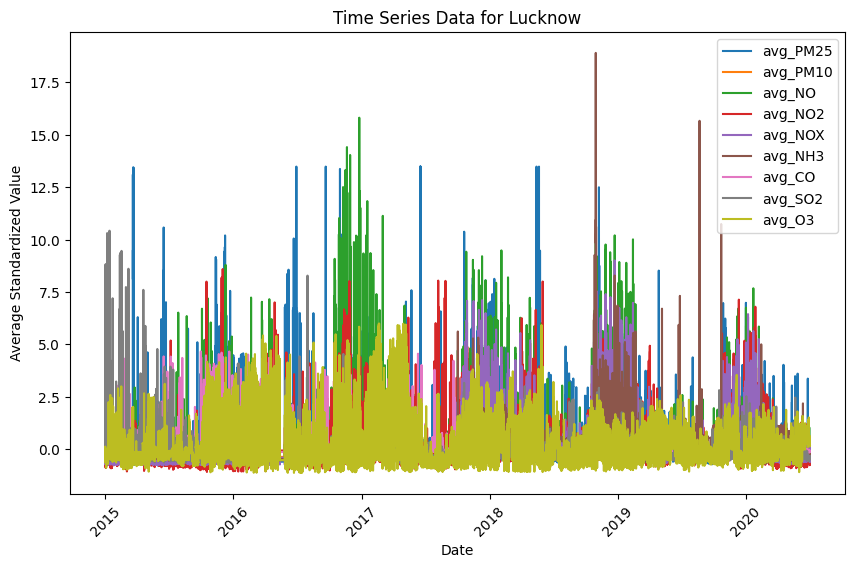

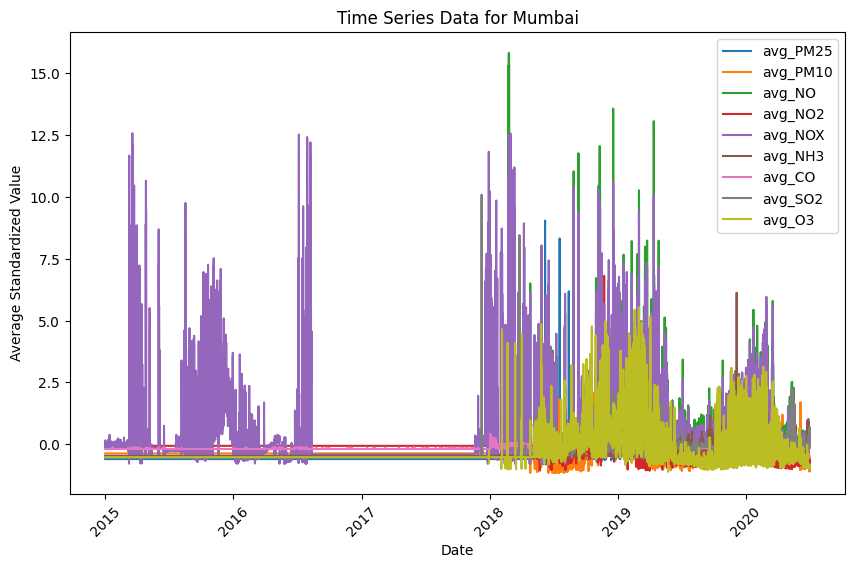

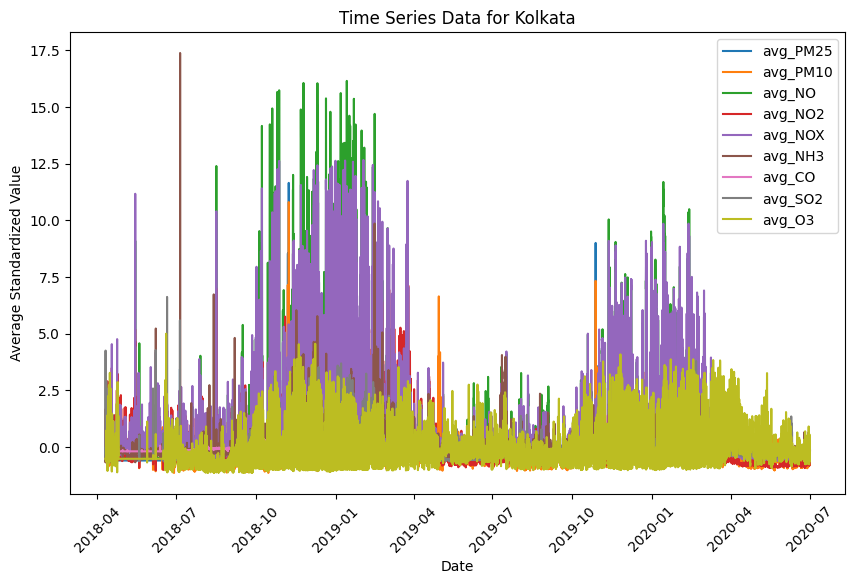

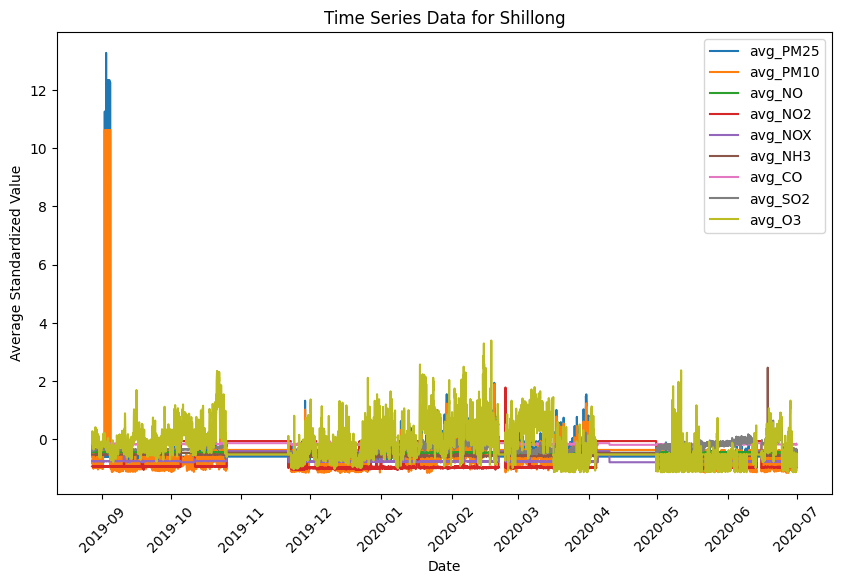

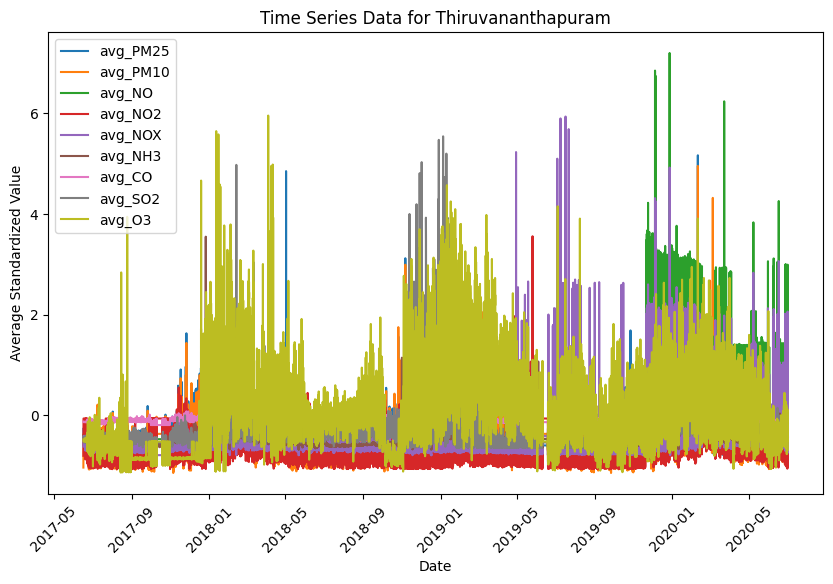

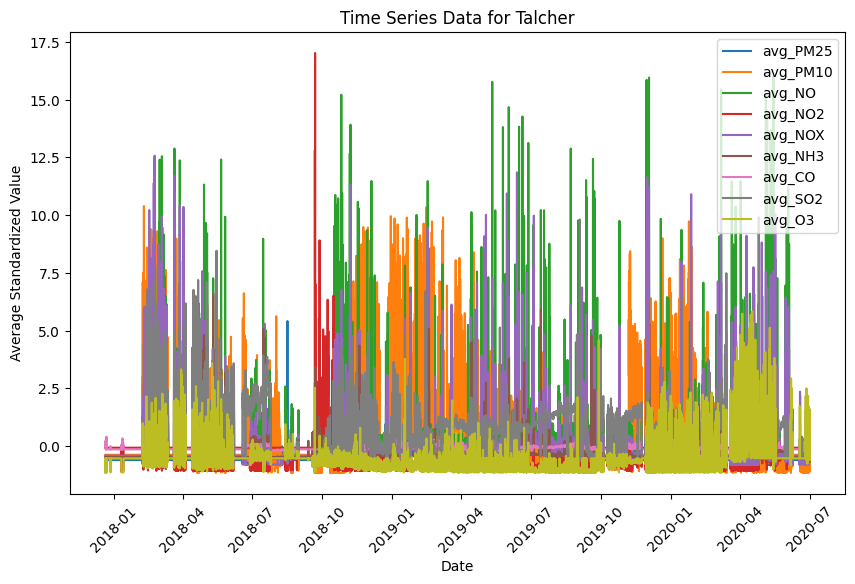

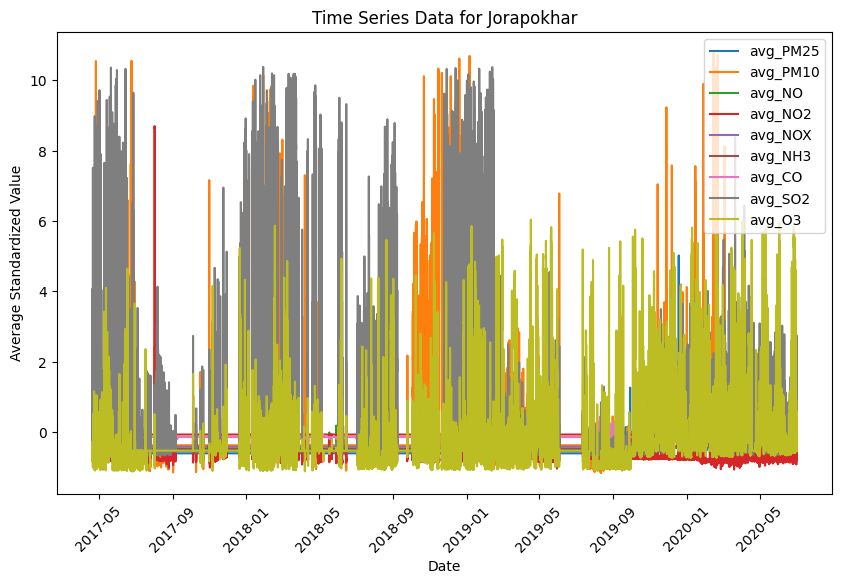

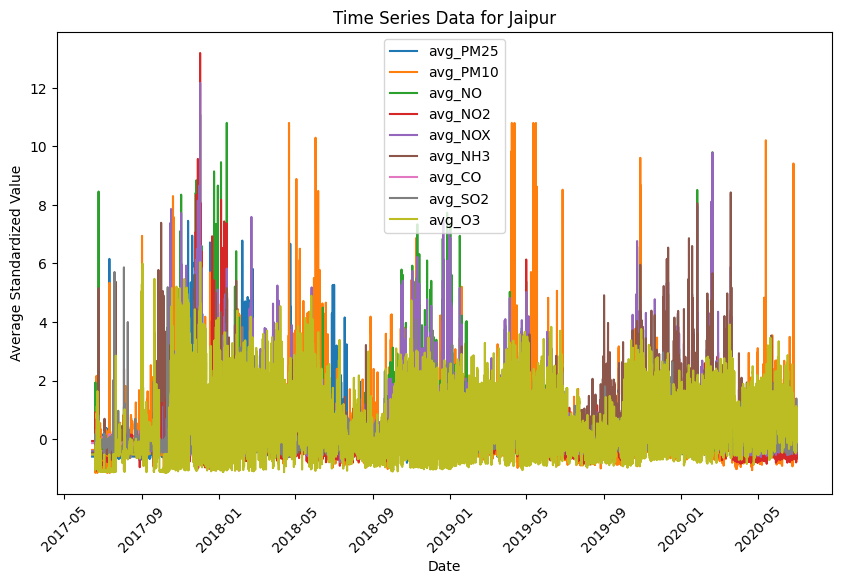

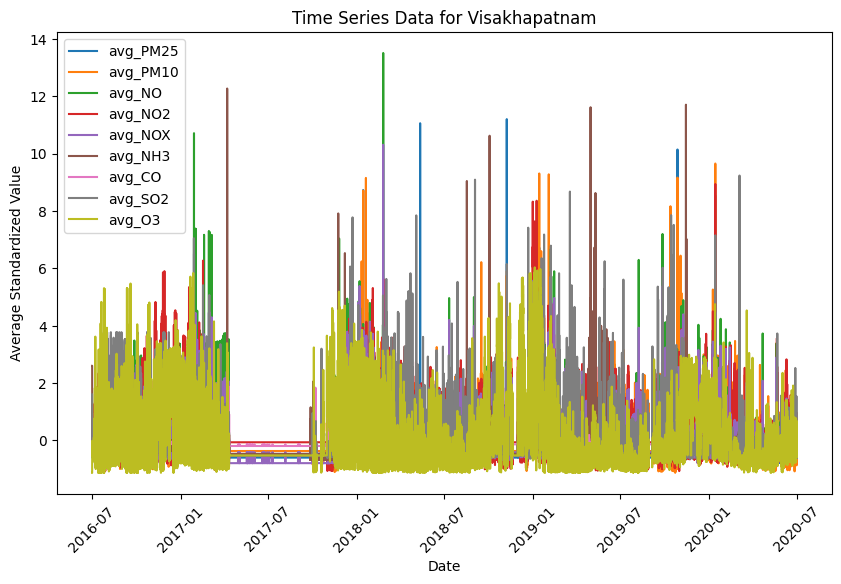

In [ ]:
standardized_df.createOrReplaceTempView("standardized_data")

# Aggregate data by city
agg_df = spark.sql("""
    SELECT
        City,
        Datetime,
        AVG(PM25) as avg_PM25,
        AVG(PM10) as avg_PM10,
        AVG(NO) as avg_NO,
        AVG(NO2) as avg_NO2,
        AVG(NOx) as avg_NOX,
        AVG(NH3) as avg_NH3,
        AVG(CO) as avg_CO,
        AVG(SO2) as avg_SO2,
        AVG(O3) as avg_O3
    FROM standardized_data
    GROUP BY City, Datetime
""")

# Retrieve time series data for each city
cities = agg_df.select("City").distinct().rdd.flatMap(lambda x: x).collect()

# Plot time series data for each city
for city in cities:
    city_data = agg_df.filter(agg_df.City == city).toPandas()
    city_data.set_index('Datetime', inplace=True)

    plt.figure(figsize=(10, 6))
    for column in city_data.columns[1:]:
        plt.plot(city_data.index, city_data[column], label=column)

    plt.title(f'Time Series Data for {city}')
    plt.xlabel('Date')
    plt.ylabel('Average Standardized Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# **Calculate AQI and Predict AQI Values**


In [ ]:
# Function to calculate PM2.5 AQI
def calculate_pm25_aqi(concentration):
    if concentration <= 12.0:
        return round((50/12) * concentration)
    elif concentration <= 35.4:
        return round((49/23.4) * (concentration - 12.1) + 51)
    elif concentration <= 55.4:
        return round((49/20) * (concentration - 35.5) + 101)
    elif concentration <= 150.4:
        return round((99/94.9) * (concentration - 55.5) + 151)
    elif concentration <= 250.4:
        return round((99/99.9) * (concentration - 150.5) + 201)
    elif concentration <= 350.4:
        return round((99/99.9) * (concentration - 250.5) + 301)
    elif concentration <= 500.4:
        return round((99/149.9) * (concentration - 350.5) + 401)
    else:
        return 500  # Maximum AQI value

# Register the UDF
calculate_pm25_aqi_udf = F.udf(calculate_pm25_aqi, IntegerType())

In [ ]:
# Function to calculate CO AQI
def calculate_co_aqi(concentration):
    concentration_ppb = concentration * 1000  # Convert from ppm to ppb
    if concentration_ppb <= 4500:
        return round((50/4500) * concentration_ppb)
    elif concentration_ppb <= 9500:
        return round((49/5000) * (concentration_ppb - 4501) + 51)
    elif concentration_ppb <= 12500:
        return round((49/3000) * (concentration_ppb - 9501) + 101)
    elif concentration_ppb <= 15500:
        return round((99/3000) * (concentration_ppb - 12501) + 151)
    elif concentration_ppb <= 30500:
        return round((99/15000) * (concentration_ppb - 15501) + 201)
    elif concentration_ppb <= 40500:
        return round((99/10000) * (concentration_ppb - 30501) + 301)
    elif concentration_ppb <= 50500:
        return round((99/10000) * (concentration_ppb - 40501) + 401)
    else:
        return 500  # Maximum AQI value

# Register the UDF
calculate_co_aqi_udf = F.udf(calculate_co_aqi, IntegerType())


In [ ]:
# Function to calculate SO2 AQI
def calculate_so2_aqi(concentration):
    concentration_ppb = concentration
    if concentration_ppb <= 35:
        return round((50/35) * concentration_ppb)
    elif concentration_ppb <= 75:
        return round((49/40) * (concentration_ppb - 36) + 51)
    elif concentration_ppb <= 185:
        return round((49/110) * (concentration_ppb - 76) + 101)
    elif concentration_ppb <= 304:
        return round((99/119) * (concentration_ppb - 186) + 151)
    elif concentration_ppb <= 604:
        return round((99/300) * (concentration_ppb - 305) + 201)
    elif concentration_ppb <= 804:
        return round((99/200) * (concentration_ppb - 605) + 301)
    elif concentration_ppb <= 1004:
        return round((99/200) * (concentration_ppb - 805) + 401)
    else:
        return 500  # Maximum AQI value

# Register the UDF
calculate_so2_aqi_udf = F.udf(calculate_so2_aqi, IntegerType())

In [ ]:
# Function to calculate O3 AQI for 8-hour average
def calculate_o3_aqi(concentration):
    if concentration <= 54:
        return round((50/54) * concentration)
    elif concentration <= 70:
        return round((49/16) * (concentration - 55) + 51)
    elif concentration <= 85:
        return round((49/15) * (concentration - 71) + 101)
    elif concentration <= 105:
        return round((99/20) * (concentration - 86) + 151)
    elif concentration <= 200:
        return round((99/95) * (concentration - 106) + 201)
    else:
        return 500  # Maximum AQI value for concentrations above 200

# Register the UDF
calculate_o3_aqi_udf = F.udf(calculate_o3_aqi, IntegerType())

In [ ]:
# Function to calculate NOx AQI
def calculate_nox_aqi(concentration):
    if concentration <= 53:
        return round((50/53) * concentration)
    elif concentration <= 100:
        return round((49/47) * (concentration - 54) + 51)
    elif concentration <= 360:
        return round((49/260) * (concentration - 101) + 101)
    elif concentration <= 649:
        return round((99/289) * (concentration - 361) + 151)
    elif concentration <= 1249:
        return round((99/600) * (concentration - 650) + 201)
    elif concentration <= 1649:
        return round((99/400) * (concentration - 1250) + 301)
    elif concentration <= 2049:
        return round((99/400) * (concentration - 1650) + 401)
    else:
        return 500  # Maximum AQI value

# Register the UDF
calculate_nox_aqi_udf = F.udf(calculate_nox_aqi, IntegerType())

In [ ]:
df.withColumn("NO2_AQI", calculate_nox_aqi_udf(df["NO2"])).show(n=700)

+---------+-------------------+------+----+------+-----+------+---+------+------+------+-------+
|     City|           Datetime|  PM25|PM10|    NO|  NO2|   NOx|NH3|    CO|   SO2|    O3|NO2_AQI|
+---------+-------------------+------+----+------+-----+------+---+------+------+------+-------+
|Ahmedabad|2015-01-01 01:00:00|  15.0|66.0|   1.0|40.01| 36.37|5.2|   1.0|122.07| 17.05|     38|
|Ahmedabad|2015-01-01 02:00:00|  15.0|66.0|  0.02|27.75| 19.73|5.2|  0.02|  85.9| 17.05|     26|
|Ahmedabad|2015-01-01 03:00:00|  15.0|66.0|  0.08|19.32| 11.08|5.2|  0.08| 52.83| 17.05|     18|
|Ahmedabad|2015-01-01 04:00:00|  15.0|66.0|   0.3|16.45|   9.2|5.2|   0.3| 39.53|153.58|     16|
|Ahmedabad|2015-01-01 05:00:00|  15.0|66.0|  0.12| 14.9|  7.85|5.2|  0.12| 32.63| 17.05|     14|
|Ahmedabad|2015-01-01 06:00:00|  15.0|66.0|  0.33|15.95| 10.82|5.2|  0.33| 29.87| 64.25|     15|
|Ahmedabad|2015-01-01 07:00:00|  15.0|66.0|  0.45|15.94| 12.47|5.2|  0.45| 27.41|191.96|     15|
|Ahmedabad|2015-01-01 08:00:00

In [ ]:
df.withColumn("NOX_AQI", calculate_nox_aqi_udf(df["NOX"])).show(n=700)

+---------+-------------------+------+----+------+-----+------+---+------+------+------+-------+
|     City|           Datetime|  PM25|PM10|    NO|  NO2|   NOx|NH3|    CO|   SO2|    O3|NOX_AQI|
+---------+-------------------+------+----+------+-----+------+---+------+------+------+-------+
|Ahmedabad|2015-01-01 01:00:00|  15.0|66.0|   1.0|40.01| 36.37|5.2|   1.0|122.07| 17.05|     34|
|Ahmedabad|2015-01-01 02:00:00|  15.0|66.0|  0.02|27.75| 19.73|5.2|  0.02|  85.9| 17.05|     19|
|Ahmedabad|2015-01-01 03:00:00|  15.0|66.0|  0.08|19.32| 11.08|5.2|  0.08| 52.83| 17.05|     10|
|Ahmedabad|2015-01-01 04:00:00|  15.0|66.0|   0.3|16.45|   9.2|5.2|   0.3| 39.53|153.58|      9|
|Ahmedabad|2015-01-01 05:00:00|  15.0|66.0|  0.12| 14.9|  7.85|5.2|  0.12| 32.63| 17.05|      7|
|Ahmedabad|2015-01-01 06:00:00|  15.0|66.0|  0.33|15.95| 10.82|5.2|  0.33| 29.87| 64.25|     10|
|Ahmedabad|2015-01-01 07:00:00|  15.0|66.0|  0.45|15.94| 12.47|5.2|  0.45| 27.41|191.96|     12|
|Ahmedabad|2015-01-01 08:00:00

In [ ]:
df.withColumn("O3_AQI", calculate_o3_aqi_udf(df["O3"])).show(n=700)

+---------+-------------------+------+----+------+-----+------+---+------+------+------+------+
|     City|           Datetime|  PM25|PM10|    NO|  NO2|   NOx|NH3|    CO|   SO2|    O3|O3_AQI|
+---------+-------------------+------+----+------+-----+------+---+------+------+------+------+
|Ahmedabad|2015-01-01 01:00:00|  15.0|66.0|   1.0|40.01| 36.37|5.2|   1.0|122.07| 17.05|    16|
|Ahmedabad|2015-01-01 02:00:00|  15.0|66.0|  0.02|27.75| 19.73|5.2|  0.02|  85.9| 17.05|    16|
|Ahmedabad|2015-01-01 03:00:00|  15.0|66.0|  0.08|19.32| 11.08|5.2|  0.08| 52.83| 17.05|    16|
|Ahmedabad|2015-01-01 04:00:00|  15.0|66.0|   0.3|16.45|   9.2|5.2|   0.3| 39.53|153.58|   251|
|Ahmedabad|2015-01-01 05:00:00|  15.0|66.0|  0.12| 14.9|  7.85|5.2|  0.12| 32.63| 17.05|    16|
|Ahmedabad|2015-01-01 06:00:00|  15.0|66.0|  0.33|15.95| 10.82|5.2|  0.33| 29.87| 64.25|    79|
|Ahmedabad|2015-01-01 07:00:00|  15.0|66.0|  0.45|15.94| 12.47|5.2|  0.45| 27.41|191.96|   291|
|Ahmedabad|2015-01-01 08:00:00|  15.0|66

In [ ]:
df.withColumn("SO2_AQI", calculate_so2_aqi_udf(df["SO2"])).show(n=700)

+---------+-------------------+------+----+------+-----+------+---+------+------+------+-------+
|     City|           Datetime|  PM25|PM10|    NO|  NO2|   NOx|NH3|    CO|   SO2|    O3|SO2_AQI|
+---------+-------------------+------+----+------+-----+------+---+------+------+------+-------+
|Ahmedabad|2015-01-01 01:00:00|  15.0|66.0|   1.0|40.01| 36.37|5.2|   1.0|122.07| 17.05|    122|
|Ahmedabad|2015-01-01 02:00:00|  15.0|66.0|  0.02|27.75| 19.73|5.2|  0.02|  85.9| 17.05|    105|
|Ahmedabad|2015-01-01 03:00:00|  15.0|66.0|  0.08|19.32| 11.08|5.2|  0.08| 52.83| 17.05|     72|
|Ahmedabad|2015-01-01 04:00:00|  15.0|66.0|   0.3|16.45|   9.2|5.2|   0.3| 39.53|153.58|     55|
|Ahmedabad|2015-01-01 05:00:00|  15.0|66.0|  0.12| 14.9|  7.85|5.2|  0.12| 32.63| 17.05|     47|
|Ahmedabad|2015-01-01 06:00:00|  15.0|66.0|  0.33|15.95| 10.82|5.2|  0.33| 29.87| 64.25|     43|
|Ahmedabad|2015-01-01 07:00:00|  15.0|66.0|  0.45|15.94| 12.47|5.2|  0.45| 27.41|191.96|     39|
|Ahmedabad|2015-01-01 08:00:00

In [ ]:
df.withColumn("CO_AQI", calculate_co_aqi_udf(df["CO"])).show(n=700)

+---------+-------------------+------+----+------+-----+------+---+------+------+------+------+
|     City|           Datetime|  PM25|PM10|    NO|  NO2|   NOx|NH3|    CO|   SO2|    O3|CO_AQI|
+---------+-------------------+------+----+------+-----+------+---+------+------+------+------+
|Ahmedabad|2015-01-01 01:00:00|  15.0|66.0|   1.0|40.01| 36.37|5.2|   1.0|122.07| 17.05|    11|
|Ahmedabad|2015-01-01 02:00:00|  15.0|66.0|  0.02|27.75| 19.73|5.2|  0.02|  85.9| 17.05|     0|
|Ahmedabad|2015-01-01 03:00:00|  15.0|66.0|  0.08|19.32| 11.08|5.2|  0.08| 52.83| 17.05|     1|
|Ahmedabad|2015-01-01 04:00:00|  15.0|66.0|   0.3|16.45|   9.2|5.2|   0.3| 39.53|153.58|     3|
|Ahmedabad|2015-01-01 05:00:00|  15.0|66.0|  0.12| 14.9|  7.85|5.2|  0.12| 32.63| 17.05|     1|
|Ahmedabad|2015-01-01 06:00:00|  15.0|66.0|  0.33|15.95| 10.82|5.2|  0.33| 29.87| 64.25|     4|
|Ahmedabad|2015-01-01 07:00:00|  15.0|66.0|  0.45|15.94| 12.47|5.2|  0.45| 27.41|191.96|     5|
|Ahmedabad|2015-01-01 08:00:00|  15.0|66

In [ ]:
df.show()

+---------+-------------------+----+----+----+-----+-----+---+----+------+------+
|     City|           Datetime|PM25|PM10|  NO|  NO2|  NOx|NH3|  CO|   SO2|    O3|
+---------+-------------------+----+----+----+-----+-----+---+----+------+------+
|Ahmedabad|2015-01-01 01:00:00|15.0|66.0| 1.0|40.01|36.37|5.2| 1.0|122.07| 17.05|
|Ahmedabad|2015-01-01 02:00:00|15.0|66.0|0.02|27.75|19.73|5.2|0.02|  85.9| 17.05|
|Ahmedabad|2015-01-01 03:00:00|15.0|66.0|0.08|19.32|11.08|5.2|0.08| 52.83| 17.05|
|Ahmedabad|2015-01-01 04:00:00|15.0|66.0| 0.3|16.45|  9.2|5.2| 0.3| 39.53|153.58|
|Ahmedabad|2015-01-01 05:00:00|15.0|66.0|0.12| 14.9| 7.85|5.2|0.12| 32.63| 17.05|
|Ahmedabad|2015-01-01 06:00:00|15.0|66.0|0.33|15.95|10.82|5.2|0.33| 29.87| 64.25|
|Ahmedabad|2015-01-01 07:00:00|15.0|66.0|0.45|15.94|12.47|5.2|0.45| 27.41|191.96|
|Ahmedabad|2015-01-01 08:00:00|15.0|66.0|1.03|16.66|16.48|5.2|1.03| 20.92|177.21|
|Ahmedabad|2015-01-01 09:00:00|15.0|66.0|1.47|16.25|18.02|5.2|1.47| 16.45|122.08|
|Ahmedabad|2015-

In [ ]:

df = df.withColumn("AQI_PM25", calculate_pm25_aqi_udf(df["PM25"]))
df = df.withColumn("AQI_NO2", calculate_nox_aqi_udf(df["NO2"]))
df = df.withColumn("AQI_SO2", calculate_so2_aqi_udf(df["SO2"]))
df = df.withColumn("AQI_CO", calculate_co_aqi_udf(df["CO"]))
df = df.withColumn("AQI_O3", calculate_o3_aqi_udf(df["O3"]))

df = df.withColumn("AQI", max_aqi_udf(col("AQI_PM25"), col("AQI_NO2"), col("AQI_SO2"), col("AQI_CO"), col("AQI_O3")))

df = df.drop("AQI_PM25", "AQI_NO2", "AQI_SO2", "AQI_CO", "AQI_O3")
df.show()

+---------+-------------------+----+----+----+-----+-----+---+----+------+------+---+
|     City|           Datetime|PM25|PM10|  NO|  NO2|  NOx|NH3|  CO|   SO2|    O3|AQI|
+---------+-------------------+----+----+----+-----+-----+---+----+------+------+---+
|Ahmedabad|2015-01-01 01:00:00|15.0|66.0| 1.0|40.01|36.37|5.2| 1.0|122.07| 17.05|122|
|Ahmedabad|2015-01-01 02:00:00|15.0|66.0|0.02|27.75|19.73|5.2|0.02|  85.9| 17.05|105|
|Ahmedabad|2015-01-01 03:00:00|15.0|66.0|0.08|19.32|11.08|5.2|0.08| 52.83| 17.05| 72|
|Ahmedabad|2015-01-01 04:00:00|15.0|66.0| 0.3|16.45|  9.2|5.2| 0.3| 39.53|153.58|251|
|Ahmedabad|2015-01-01 05:00:00|15.0|66.0|0.12| 14.9| 7.85|5.2|0.12| 32.63| 17.05| 57|
|Ahmedabad|2015-01-01 06:00:00|15.0|66.0|0.33|15.95|10.82|5.2|0.33| 29.87| 64.25| 79|
|Ahmedabad|2015-01-01 07:00:00|15.0|66.0|0.45|15.94|12.47|5.2|0.45| 27.41|191.96|291|
|Ahmedabad|2015-01-01 08:00:00|15.0|66.0|1.03|16.66|16.48|5.2|1.03| 20.92|177.21|275|
|Ahmedabad|2015-01-01 09:00:00|15.0|66.0|1.47|16.25|18

In [ ]:
def assign_aqi_bucket(df):
    return df.withColumn(
        "AQI_Bucket",
        when((col("AQI") >= 0) & (col("AQI") <= 50), "Good")
        .when((col("AQI") > 50) & (col("AQI") <= 100), "Satisfactory")
        .when((col("AQI") > 100) & (col("AQI") <= 200), "Moderately Polluted")
        .when((col("AQI") > 200) & (col("AQI") <= 300), "Poor")
        .when((col("AQI") > 300) & (col("AQI") <= 400), "Very Poor")
        .when((col("AQI") > 400) & (col("AQI") <= 500), "Severe")
    )

In [ ]:
from pyspark.sql.functions import col

null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+----+--------+----+----+---+---+---+---+---+---+---+---+
|City|Datetime|PM25|PM10| NO|NO2|NOx|NH3| CO|SO2| O3|AQI|
+----+--------+----+----+---+---+---+---+---+---+---+---+
|   0|       0|   0|   0|  0|  0|  0|  0|  0|  0|  0|  0|
+----+--------+----+----+---+---+---+---+---+---+---+---+



In [ ]:
df_clean = df.dropna(how='all')
df_clean.show()

+---------+-------------------+----+----+----+-----+-----+---+----+------+------+---+
|     City|           Datetime|PM25|PM10|  NO|  NO2|  NOx|NH3|  CO|   SO2|    O3|AQI|
+---------+-------------------+----+----+----+-----+-----+---+----+------+------+---+
|Ahmedabad|2015-01-01 01:00:00|15.0|66.0| 1.0|40.01|36.37|5.2| 1.0|122.07| 17.05|122|
|Ahmedabad|2015-01-01 02:00:00|15.0|66.0|0.02|27.75|19.73|5.2|0.02|  85.9| 17.05|105|
|Ahmedabad|2015-01-01 03:00:00|15.0|66.0|0.08|19.32|11.08|5.2|0.08| 52.83| 17.05| 72|
|Ahmedabad|2015-01-01 04:00:00|15.0|66.0| 0.3|16.45|  9.2|5.2| 0.3| 39.53|153.58|251|
|Ahmedabad|2015-01-01 05:00:00|15.0|66.0|0.12| 14.9| 7.85|5.2|0.12| 32.63| 17.05| 57|
|Ahmedabad|2015-01-01 06:00:00|15.0|66.0|0.33|15.95|10.82|5.2|0.33| 29.87| 64.25| 79|
|Ahmedabad|2015-01-01 07:00:00|15.0|66.0|0.45|15.94|12.47|5.2|0.45| 27.41|191.96|291|
|Ahmedabad|2015-01-01 08:00:00|15.0|66.0|1.03|16.66|16.48|5.2|1.03| 20.92|177.21|275|
|Ahmedabad|2015-01-01 09:00:00|15.0|66.0|1.47|16.25|18

The impact of PM25 on AQI


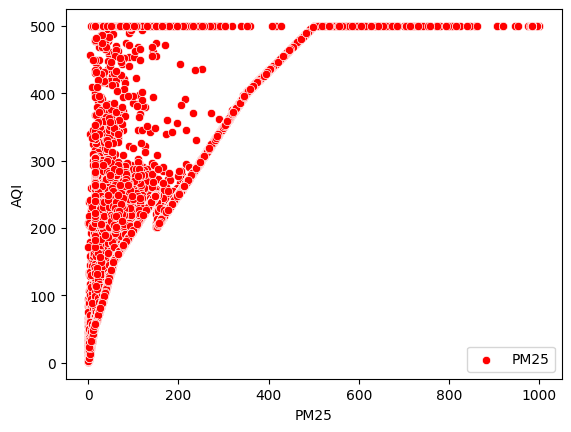

The impact of PM10 on AQI


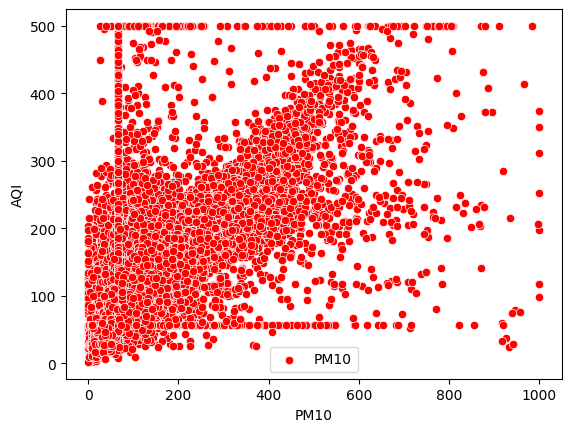

The impact of NO on AQI


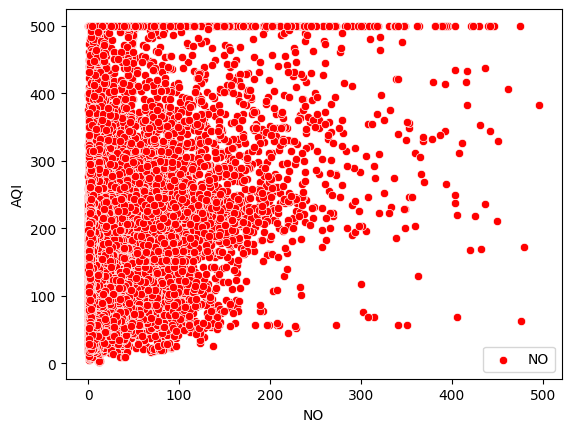

The impact of NO2 on AQI


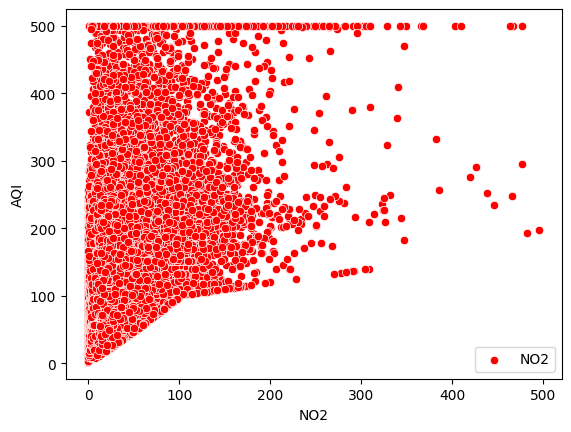

The impact of NOx on AQI


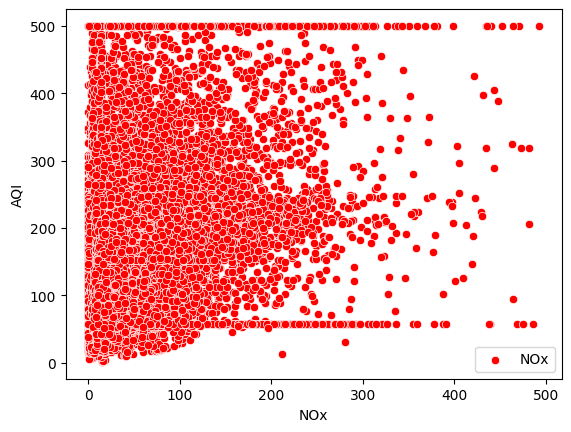

The impact of NH3 on AQI


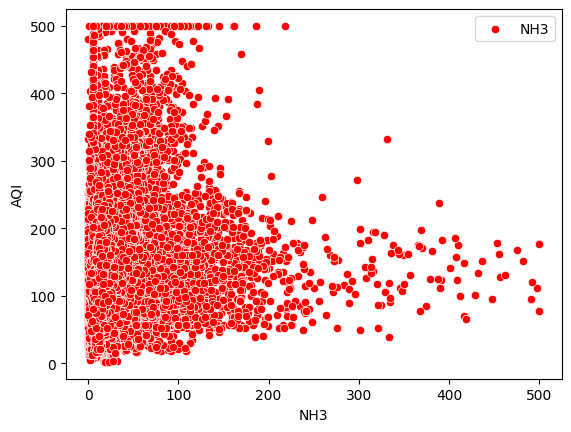

The impact of CO on AQI


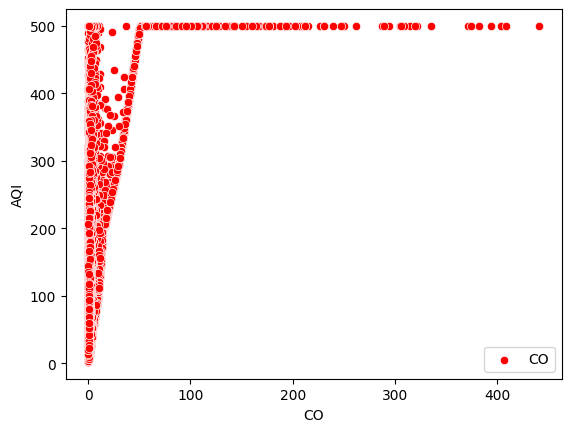

The impact of SO2 on AQI


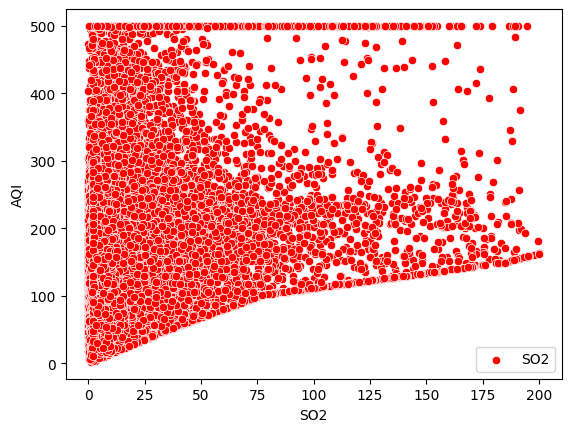

In [ ]:
for column in df.columns[2:10]:
    print(f'The impact of {column} on AQI')

    sampled_df = df.select(column, "AQI").sample(fraction=0.1, withReplacement=False)

    pd_sampled = sampled_df.toPandas()

    sns.scatterplot(x=column, y='AQI', data=pd_sampled, marker="o", sizes=200, color="r", label=column)
    plt.legend()
    plt.show()

In [ ]:
df_clean

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int]

### Time-based feature adding

In [ ]:
from pyspark.sql.functions import year, month, dayofmonth, hour

df_clean = df_clean.withColumn("year", year(col("Datetime")))
df_clean = df_clean.withColumn("month", month(col("Datetime")))
df_clean = df_clean.withColumn("day", dayofmonth(col("Datetime")))
df_clean = df_clean.withColumn("hour", hour(col("Datetime")))

### Group dataset by each region

In [ ]:
regions = df_clean.select("City").distinct().rdd.flatMap(lambda x: x).collect()

region_data_frames = {region: df_clean.filter(col("City") == region) for region in regions}

In [ ]:
len(regions)

26

### Regression Model

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

assembler = VectorAssembler(
    inputCols=["year", "month", "day", "hour", "lag_1"],
    outputCol="features"
)

rf = RandomForestRegressor(featuresCol="features", labelCol="AQI", numTrees=5, maxDepth=5)

pipeline = Pipeline(stages=[assembler, rf])

### Function to plot predictions

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date

def aqi_prediction(lr_predictions):
  lr_predictions = lr_predictions.withColumn("Datetime", to_date(col("Datetime")))

  actual_aqi = lr_predictions.select("AQI").rdd.flatMap(lambda x: x).collect()
  predicted_aqi = lr_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
  dates = lr_predictions.select("Datetime").rdd.flatMap(lambda x: x).collect()

  import pandas as pd
  plot_df = pd.DataFrame({'Datetime': dates, 'Actual AQI': actual_aqi, 'Predicted AQI': predicted_aqi})
  plot_df.sort_values('Datetime', inplace=True)

  plt.figure(figsize=(10, 6))
  plt.plot(plot_df['Datetime'], plot_df['Actual AQI'], label="Actual AQI")
  plt.plot(plot_df['Datetime'], plot_df['Predicted AQI'], label="Predicted AQI")
  plt.xlabel("Datetime")
  plt.ylabel("AQI")
  plt.title("Actual vs Predicted AQI")
  plt.legend()
  plt.show()

### Predicting AQI for each region

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+---------+---+------------------+
|     City|aqi|        prediction|
+---------+---+------------------+
|Ernakulam| 25| 57.27706956740252|
|Ernakulam| 25| 62.39366531208337|
|Ernakulam| 30| 62.39366531208337|
|Ernakulam| 50| 62.39366531208337|
|Ernakulam| 46| 66.41746972809645|
|Ernakulam| 51| 63.79080306142978|
|Ernakulam| 61| 63.79080306142978|
|Ernakulam| 46| 63.79080306142978|
|Ernakulam| 61| 63.79080306142978|
|Ernakulam| 51| 60.51437553358561|
|Ernakulam| 53| 60.51437553358561|
|Ernakulam| 33|  58.1051059934591|
|Ernakulam| 25| 55.60281648115728|
|Ernakulam| 25| 53.89367296263875|
|Ernakulam| 25| 53.89367296263875|
|Ernakulam| 33| 53.89367296263875|
|Ernakulam| 37| 53.89367296263875|
|Ernakulam| 29|54.930033137776775|
|Ernakulam| 25|54.930033137776775|
|Er

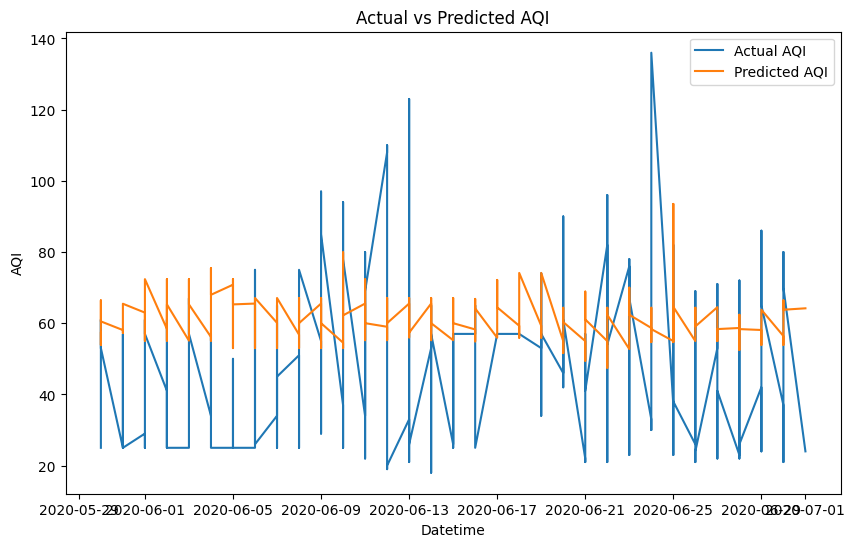

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+-------+---+------------------+
|   City|aqi|        prediction|
+-------+---+------------------+
|Chennai|201|148.99044265567267|
|Chennai|236| 146.4137235023956|
|Chennai|152|132.76102574107148|
|Chennai|153| 134.8525599770275|
|Chennai|155|132.76102574107148|
|Chennai|139| 116.1378908752883|
|Chennai|127|132.76102574107148|
|Chennai|124|124.87307649035422|
|Chennai|107|132.76102574107148|
|Chennai|101| 132.6903166816209|
|Chennai| 92| 132.6903166816209|
|Chennai| 80|122.04186588662128|
|Chennai| 85|110.40091070253109|
|Chennai| 92|107.67660293254622|
|Chennai|112|122.37204518252494|
|Chennai| 98|133.02049597752458|
|Chennai| 89|124.49770513463088|
|Chennai| 93|112.33771930689849|
|Chennai|104|113.41358310530343|
|Chennai|119|113.41358310530343|
+-------+---+-

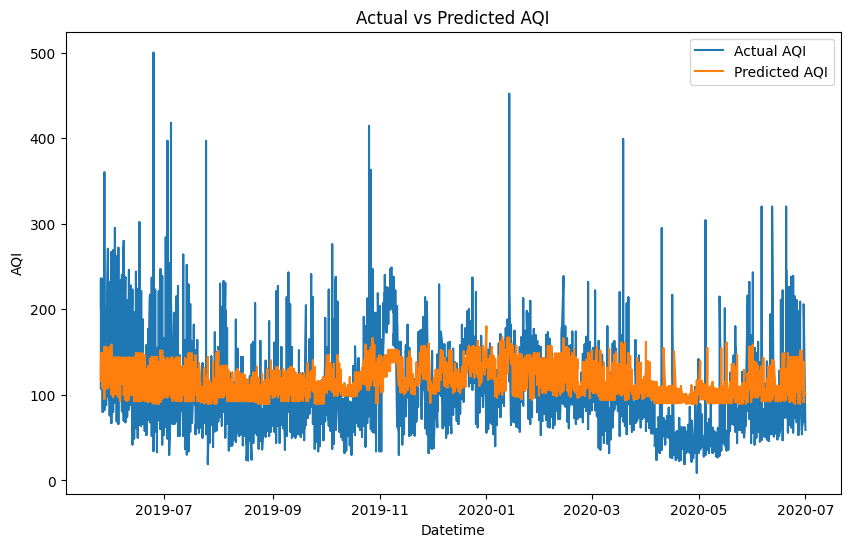

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+------+---+------------------+
|  City|aqi|        prediction|
+------+---+------------------+
|Aizawl| 53| 46.78361739905067|
|Aizawl| 57| 62.79384031032057|
|Aizawl| 57| 46.78361739905067|
|Aizawl| 50|56.200608168166376|
|Aizawl| 42|56.200608168166376|
|Aizawl| 42|56.200608168166376|
|Aizawl| 57|56.200608168166376|
|Aizawl| 57|56.200608168166376|
|Aizawl| 24| 60.71042627482202|
|Aizawl| 28|55.339896706457196|
|Aizawl| 50| 62.23691050799623|
|Aizawl| 57| 62.23691050799623|
|Aizawl| 42| 65.87803581700099|
|Aizawl| 46| 65.23456255210134|
|Aizawl| 37| 58.59711333118397|
|Aizawl| 57| 65.23456255210134|
|Aizawl| 33| 58.59711333118397|
|Aizawl| 50| 65.23456255210134|
|Aizawl| 50| 58.59711333118397|
|Aizawl| 50| 58.59711333118397|
+------+---+------------------+
only 

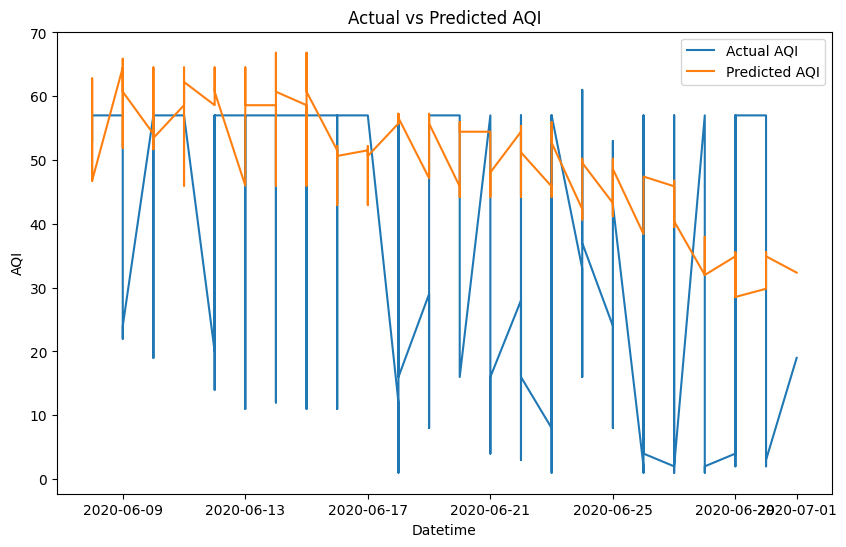

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+---------+---+------------------+
|     City|aqi|        prediction|
+---------+---+------------------+
|Ahmedabad|185|190.22732764250242|
|Ahmedabad|179|190.22732764250242|
|Ahmedabad|179|167.11538419703194|
|Ahmedabad|159|167.11538419703194|
|Ahmedabad|238|167.11538419703194|
|Ahmedabad|215|226.65385794369695|
|Ahmedabad|214|363.54694708375195|
|Ahmedabad|229| 325.6619876495508|
|Ahmedabad|234| 325.6619876495508|
|Ahmedabad|279| 231.2486061695021|
|Ahmedabad|363| 256.4382344766272|
|Ahmedabad|209|210.63801060187515|
|Ahmedabad|156|234.70973894325863|
|Ahmedabad|141|272.59469837745985|
|Ahmedabad|282|272.59469837745985|
|Ahmedabad|244|272.59469837745985|
|Ahmedabad|320|272.59469837745985|
|Ahmedabad|357|234.70973894325863|
|Ahmedabad|284| 198.6056953309392|
|Ah

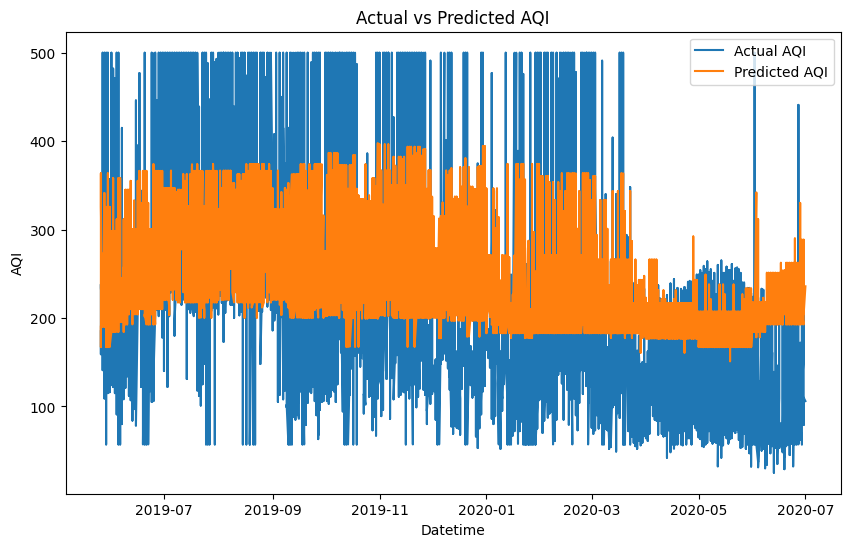

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+--------+---+------------------+
|    City|aqi|        prediction|
+--------+---+------------------+
|Gurugram| 95|120.29304536383256|
|Gurugram| 76|106.96153657200048|
|Gurugram| 75|120.29304536383256|
|Gurugram| 94|106.96153657200048|
|Gurugram| 86|106.96153657200048|
|Gurugram|104|106.96153657200048|
|Gurugram| 89|126.90540009450983|
|Gurugram| 69|126.90540009450983|
|Gurugram| 87|142.93171236415816|
|Gurugram| 85|126.90540009450983|
|Gurugram| 93|126.90540009450983|
|Gurugram|102|126.90540009450983|
|Gurugram|113|126.90540009450983|
|Gurugram| 99|126.90540009450983|
|Gurugram|121|126.90540009450983|
|Gurugram|147|126.90540009450983|
|Gurugram| 97|126.90540009450983|
|Gurugram| 86|126.90540009450983|
|Gurugram| 92|126.90540009450983|
|Gurugram|120|126.9054000

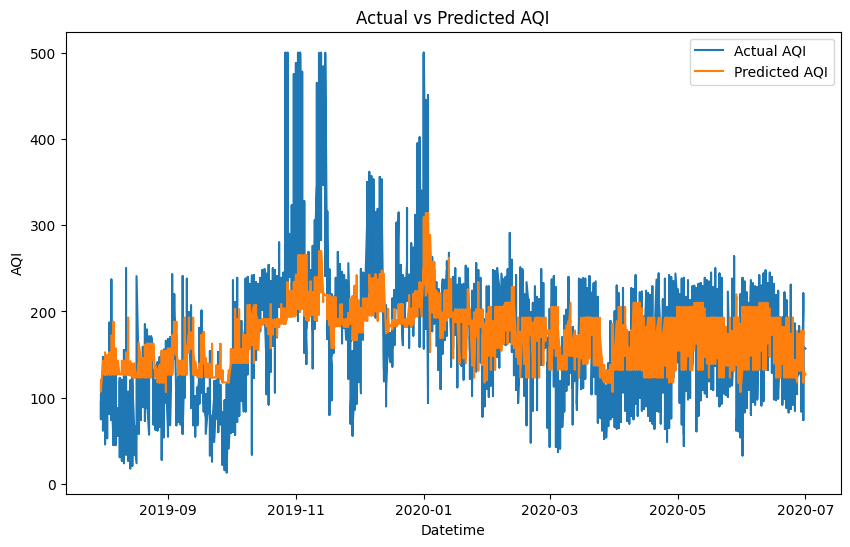

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+------------+---+------------------+
|        City|aqi|        prediction|
+------------+---+------------------+
|Brajrajnagar|185|142.52426067904653|
|Brajrajnagar|178|149.66265519247594|
|Brajrajnagar|181|142.52426067904653|
|Brajrajnagar|175|142.52426067904653|
|Brajrajnagar|180|127.56382403488507|
|Brajrajnagar|166|127.56382403488507|
|Brajrajnagar|168|127.56382403488507|
|Brajrajnagar|168|146.12432608799264|
|Brajrajnagar|180|146.12432608799264|
|Brajrajnagar|191|146.12432608799264|
|Brajrajnagar|189|131.22769992216018|
|Brajrajnagar|174|127.82410595589468|
|Brajrajnagar|160|127.82410595589468|
|Brajrajnagar|175|127.82410595589468|
|Brajrajnagar|166|127.82410595589468|
|Brajrajnagar|127|  76.7939162208484|
|Brajrajnagar|130|  76.7939162208484|
|Brajrajnagar

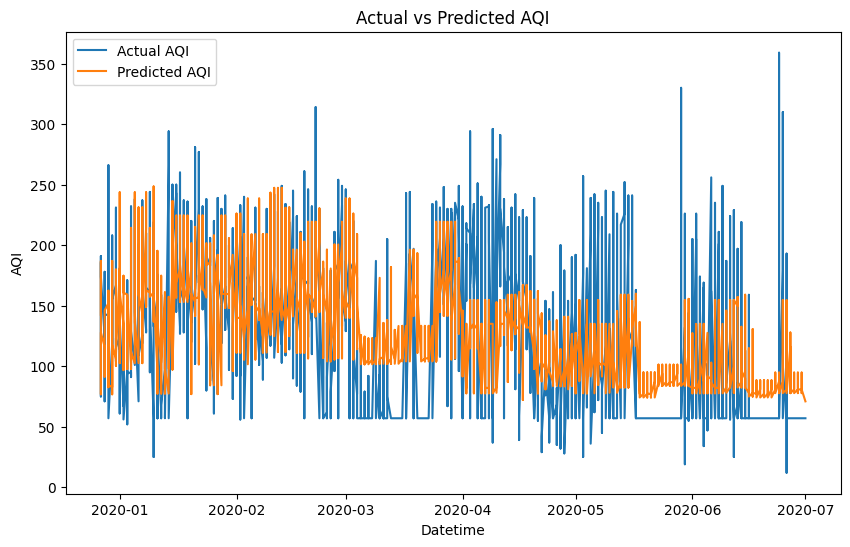

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+---------+---+------------------+
|     City|aqi|        prediction|
+---------+---+------------------+
|Amaravati|191|147.49143405057433|
|Amaravati|182|147.49143405057433|
|Amaravati|168|147.49143405057433|
|Amaravati|158|147.49143405057433|
|Amaravati|153|143.93608759754028|
|Amaravati|159|143.93608759754028|
|Amaravati|163|143.93608759754028|
|Amaravati|170|143.93608759754028|
|Amaravati|168|143.93608759754028|
|Amaravati|174|139.95711814581716|
|Amaravati|189|139.95711814581716|
|Amaravati|192|139.95711814581716|
|Amaravati|173|143.93608759754028|
|Amaravati|177|143.93608759754028|
|Amaravati|183|143.93608759754028|
|Amaravati|204|143.45565770659127|
|Amaravati|209|147.49143405057433|
|Amaravati|214|143.45565770659127|
|Amaravati|209|143.45565770659127|
|Am

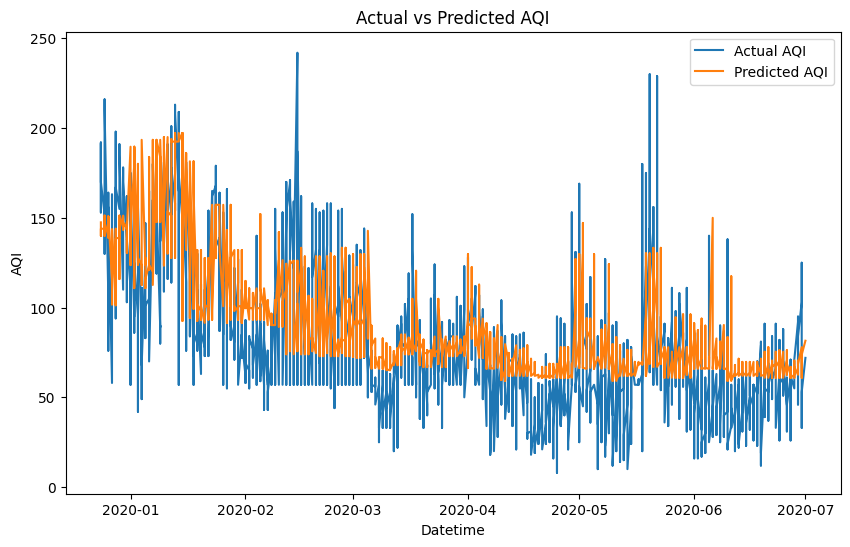

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+--------+---+------------------+
|    City|aqi|        prediction|
+--------+---+------------------+
|Amritsar|220|129.37683321660225|
|Amritsar|244|129.37683321660225|
|Amritsar|220|173.93234760559963|
|Amritsar|202|173.93234760559963|
|Amritsar|212|173.93234760559963|
|Amritsar|223|173.93234760559963|
|Amritsar|204|173.93234760559963|
|Amritsar|170|173.93234760559963|
|Amritsar|176|173.93234760559963|
|Amritsar|178|173.93234760559963|
|Amritsar|172|173.93234760559963|
|Amritsar|191|173.93234760559963|
|Amritsar|208|173.93234760559963|
|Amritsar|220|173.93234760559963|
|Amritsar|236|173.93234760559963|
|Amritsar|243|173.93234760559963|
|Amritsar|210|155.43913544571507|
|Amritsar|230|155.43913544571507|
|Amritsar|223|155.43913544571507|
|Amritsar|206|155.4391354

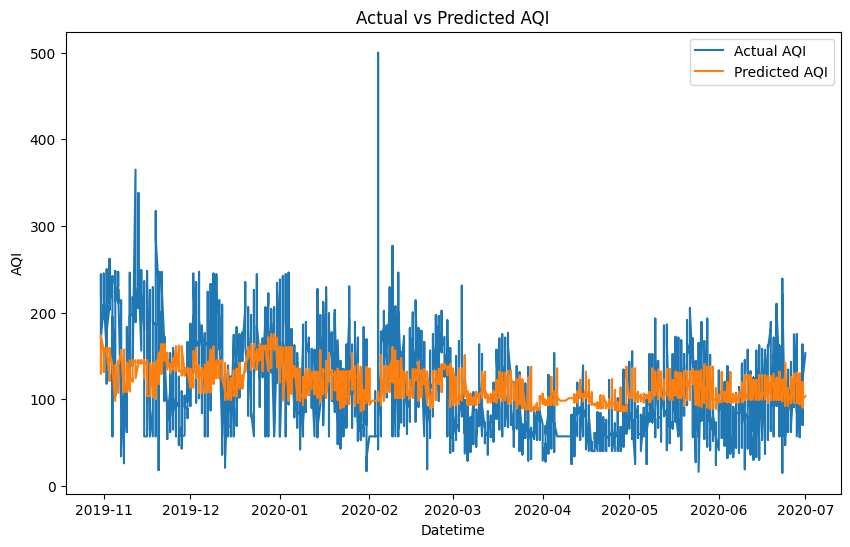

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+-----+---+------------------+
| City|aqi|        prediction|
+-----+---+------------------+
|Delhi|212|161.15888340423476|
|Delhi|219|157.13514299890866|
|Delhi|187|150.71411219322147|
|Delhi|141|150.71411219322147|
|Delhi| 91|150.71411219322147|
|Delhi| 91|150.71411219322147|
|Delhi|129|150.71411219322147|
|Delhi|154|150.71411219322147|
|Delhi|160|157.13514299890866|
|Delhi|163| 173.3678024376454|
|Delhi|164| 173.3678024376454|
|Delhi|163| 173.3678024376454|
|Delhi|164| 174.6674737397946|
|Delhi|165| 174.6674737397946|
|Delhi|171| 174.6674737397946|
|Delhi|181|187.14134146647575|
|Delhi|204|192.96764823288828|
|Delhi|220| 211.4570110961675|
|Delhi|219| 205.4055435685156|
|Delhi|194|187.14134146647575|
+-----+---+------------------+
only showing top 20 rows



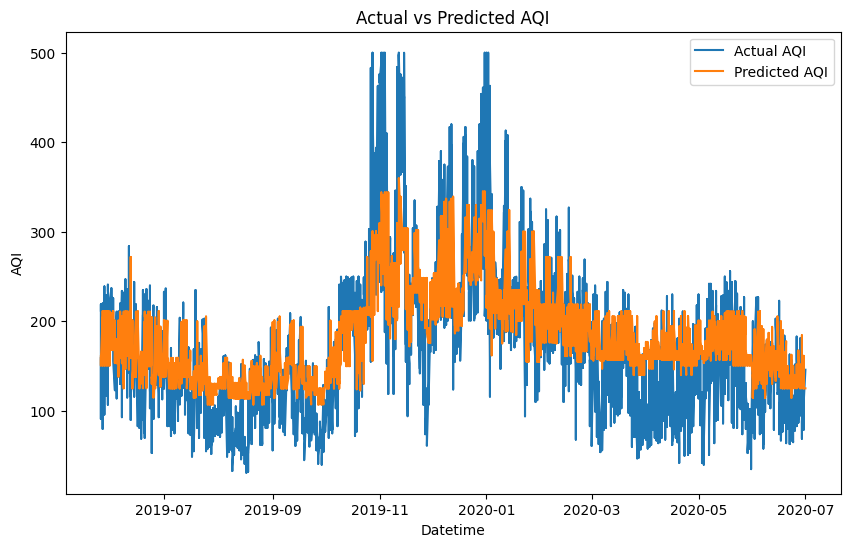

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+----------+---+-----------------+
|      City|aqi|       prediction|
+----------+---+-----------------+
|Chandigarh| 58|60.46301603824518|
|Chandigarh| 85|53.07240389702197|
|Chandigarh|101| 61.7443020031287|
|Chandigarh| 95|60.46301603824518|
|Chandigarh| 83|70.32396363066579|
|Chandigarh| 79|67.18486106656323|
|Chandigarh| 76|67.18486106656323|
|Chandigarh| 90|53.07240389702197|
|Chandigarh| 99|60.46301603824518|
|Chandigarh| 97|67.51596192215703|
|Chandigarh| 86|71.48191980010597|
|Chandigarh| 80|71.48191980010597|
|Chandigarh| 69|67.51596192215703|
|Chandigarh| 58| 61.7443020031287|
|Chandigarh| 58|  71.648117643519|
|Chandigarh| 57|  71.648117643519|
|Chandigarh| 49|67.51596192215703|
|Chandigarh| 47|60.46301603824518|
|Chandigarh| 51|53.07240389702197|
|Ch

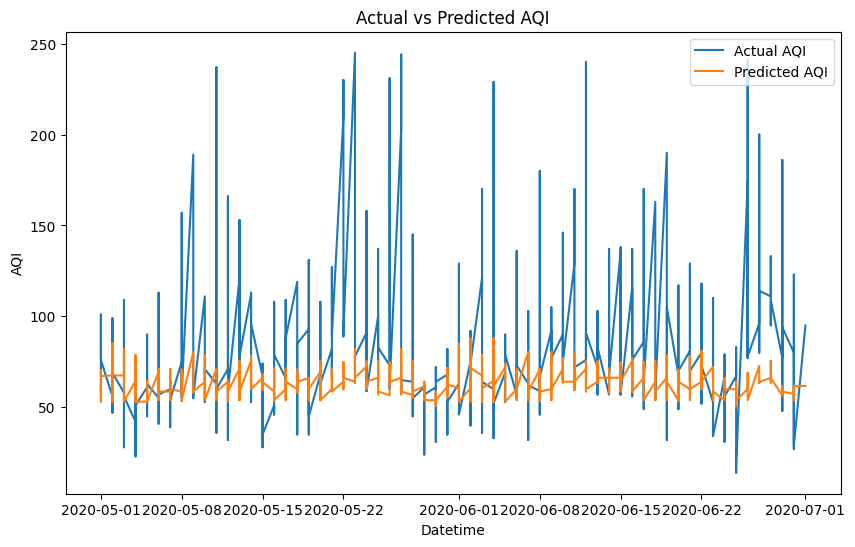

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+----------+---+-----------------+
|      City|aqi|       prediction|
+----------+---+-----------------+
|Coimbatore| 68|71.21182651913126|
|Coimbatore| 67|73.00794850589043|
|Coimbatore| 67|75.92084101191726|
|Coimbatore| 68|87.25903290369222|
|Coimbatore| 69|83.23757175531556|
|Coimbatore| 63|83.23757175531556|
|Coimbatore| 64|83.23757175531556|
|Coimbatore| 82|85.65650281302946|
|Coimbatore| 76|85.65650281302946|
|Coimbatore| 83|85.65650281302946|
|Coimbatore| 70|85.65650281302946|
|Coimbatore| 70| 87.5993529109584|
|Coimbatore| 66| 89.6779639614061|
|Coimbatore| 79| 89.6779639614061|
|Coimbatore| 79| 89.6779639614061|
|Coimbatore| 80| 89.6779639614061|
|Coimbatore| 78|78.52452716133948|
|Coimbatore| 77|78.52452716133948|
|Coimbatore| 72|78.52452716133948|
|Co

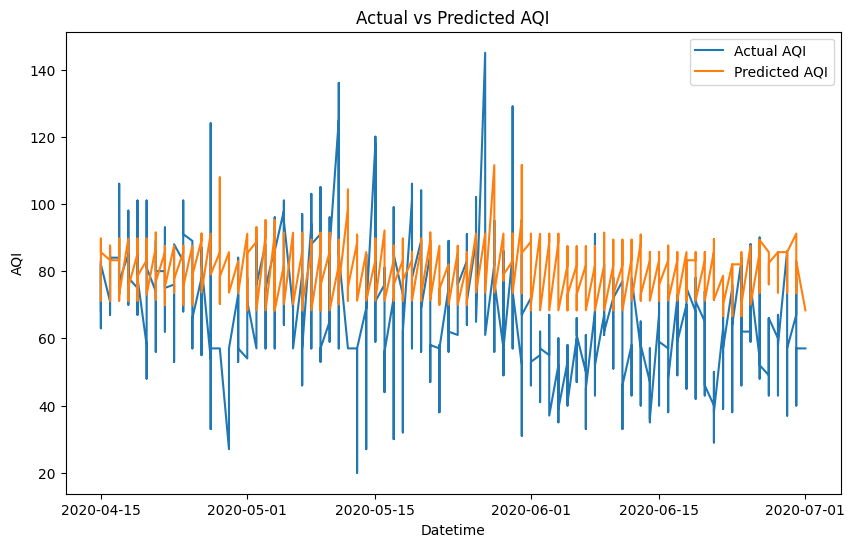

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+------+---+------------------+
|  City|aqi|        prediction|
+------+---+------------------+
|Bhopal|120|144.00433847143933|
|Bhopal|117|140.03081845640455|
|Bhopal|104|115.75385612410318|
|Bhopal| 84|101.78225393224606|
|Bhopal| 79|101.78225393224606|
|Bhopal| 81|101.78225393224606|
|Bhopal|129|101.78225393224606|
|Bhopal|125| 114.2104705500727|
|Bhopal|141|119.92435507499172|
|Bhopal|138|125.55791473689433|
|Bhopal|137|112.37846044472926|
|Bhopal|132|110.48388253348469|
|Bhopal|123|110.48388253348469|
|Bhopal|109|110.48388253348469|
|Bhopal| 96| 112.5819520315542|
|Bhopal|128|112.37846044472926|
|Bhopal|145|137.59532405539755|
|Bhopal|227| 155.0720643685426|
|Bhopal|203|105.71622540371752|
|Bhopal|240|105.71622540371752|
+------+---+------------------+
only 

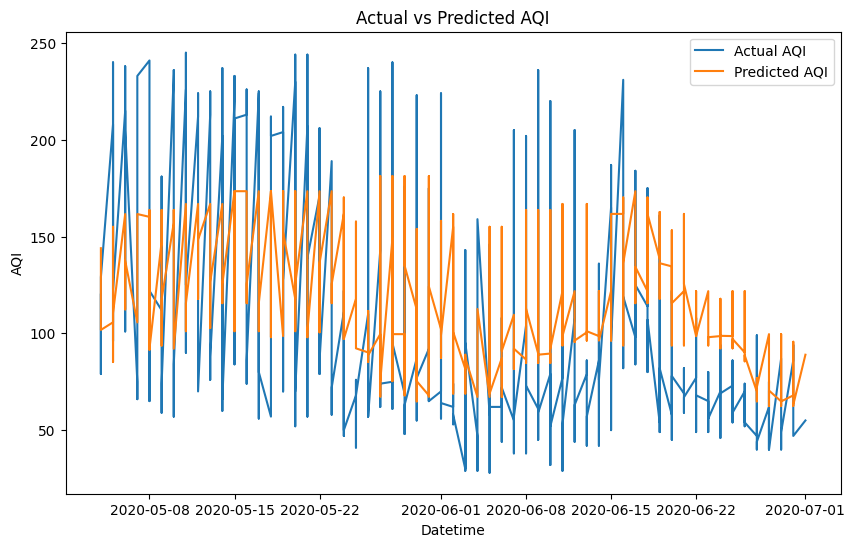

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+---------+---+------------------+
|     City|aqi|        prediction|
+---------+---+------------------+
|Bengaluru|187|143.52363746010639|
|Bengaluru|163| 150.6479234046583|
|Bengaluru|146| 150.6479234046583|
|Bengaluru|132|135.71823747207918|
|Bengaluru|107|134.89209481810258|
|Bengaluru| 81|134.89209481810258|
|Bengaluru| 86|124.50341903273836|
|Bengaluru| 90|120.45828662840525|
|Bengaluru| 69|120.45828662840525|
|Bengaluru| 85| 88.29312409625649|
|Bengaluru| 71| 88.29312409625649|
|Bengaluru| 59| 88.25676549097084|
|Bengaluru| 58| 88.25676549097084|
|Bengaluru| 55| 88.25676549097084|
|Bengaluru| 56| 88.25676549097084|
|Bengaluru| 57| 88.25676549097084|
|Bengaluru| 63| 88.25676549097084|
|Bengaluru| 85| 88.25676549097084|
|Bengaluru| 85| 88.25676549097084|
|Be

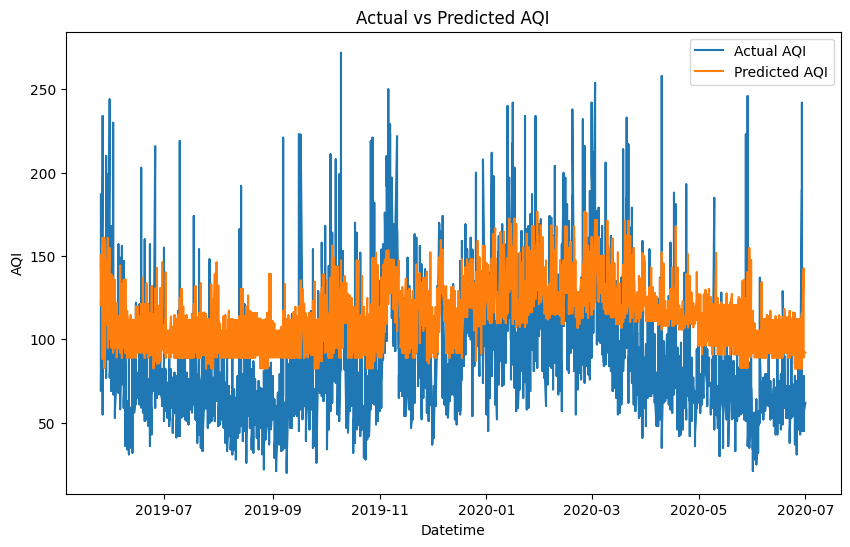

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+---------+---+------------------+
|     City|aqi|        prediction|
+---------+---+------------------+
|Hyderabad| 87|113.93311481954213|
|Hyderabad| 96|113.93311481954213|
|Hyderabad| 85|113.93311481954213|
|Hyderabad| 93|113.93311481954213|
|Hyderabad| 96|118.59336990652533|
|Hyderabad| 98|118.59336990652533|
|Hyderabad| 98|113.93311481954213|
|Hyderabad|110|113.93311481954213|
|Hyderabad|100|115.39214373389021|
|Hyderabad| 92|115.39214373389021|
|Hyderabad| 97|115.39214373389021|
|Hyderabad|106|115.39214373389021|
|Hyderabad|125|115.39214373389021|
|Hyderabad|146|147.28542327433462|
|Hyderabad|156|148.36352283381552|
|Hyderabad|158|146.72384747149667|
|Hyderabad|157|123.97355701040655|
|Hyderabad|144|123.97355701040655|
|Hyderabad|122|122.16029793390526|
|Hy

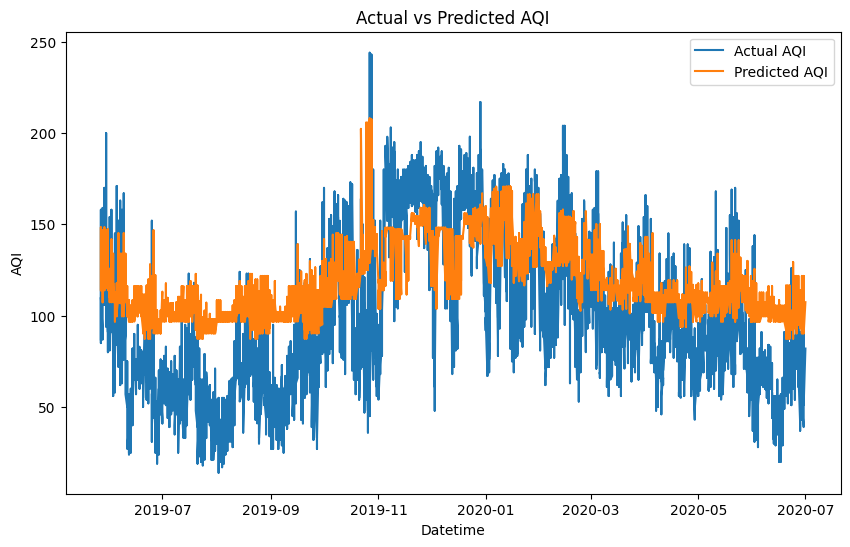

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+--------+---+------------------+
|    City|aqi|        prediction|
+--------+---+------------------+
|Guwahati|197| 182.0853122098059|
|Guwahati|204| 182.0853122098059|
|Guwahati|201| 182.0853122098059|
|Guwahati|197| 178.0089249763269|
|Guwahati|175| 178.0089249763269|
|Guwahati|176| 164.0567590463651|
|Guwahati|165| 164.0567590463651|
|Guwahati|154|172.32146332740322|
|Guwahati|134|153.91037553164523|
|Guwahati|137|172.32146332740322|
|Guwahati| 95| 194.0811145248131|
|Guwahati| 97|172.32146332740322|
|Guwahati|123|172.32146332740322|
|Guwahati|141|172.32146332740322|
|Guwahati|161|187.08622980579486|
|Guwahati|159|233.52532787105366|
|Guwahati|141|216.37784158295398|
|Guwahati|164|216.37784158295398|
|Guwahati|164|216.37784158295398|
|Guwahati|178|218.1518548

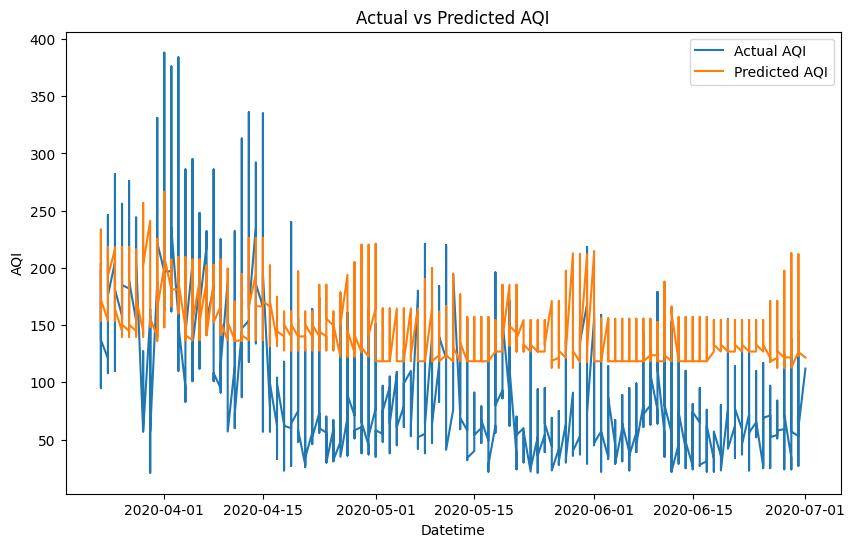

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+-----+---+------------------+
| City|aqi|        prediction|
+-----+---+------------------+
|Kochi| 57| 66.03916159754813|
|Kochi| 57| 66.03916159754813|
|Kochi| 20|63.874719900180615|
|Kochi| 76|63.874719900180615|
|Kochi| 57| 64.09164972474203|
|Kochi| 21| 64.09164972474203|
|Kochi|105|63.874719900180615|
|Kochi| 19|62.578648669889695|
|Kochi| 53|62.578648669889695|
|Kochi| 59| 62.10048588610702|
|Kochi| 61| 59.47559699721813|
|Kochi| 65|   57.693634764049|
|Kochi| 65|   57.693634764049|
|Kochi| 61|   57.693634764049|
|Kochi| 67|   57.693634764049|
|Kochi| 57|   57.693634764049|
|Kochi| 52|   57.693634764049|
|Kochi| 85| 64.53936633640035|
|Kochi| 33|  69.1354717201346|
|Kochi| 25| 71.40361244239253|
+-----+---+------------------+
only showing top 20 rows



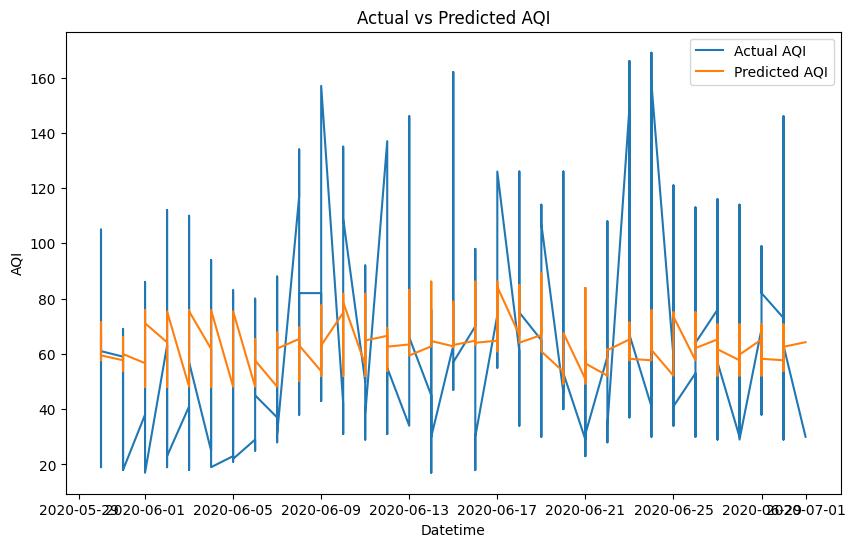

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+-----+---+------------------+
| City|aqi|        prediction|
+-----+---+------------------+
|Patna|173|171.25546720865452|
|Patna|176|152.40945249316636|
|Patna|177|152.40945249316636|
|Patna|165|152.40945249316636|
|Patna|151|152.40945249316636|
|Patna|143|152.40945249316636|
|Patna|164|152.40945249316636|
|Patna|170|152.40945249316636|
|Patna|216|152.40945249316636|
|Patna|177|  173.958510898208|
|Patna|173|168.40135330967453|
|Patna|135|160.38975313494754|
|Patna|124|160.38975313494754|
|Patna|143|160.38975313494754|
|Patna|132|160.38975313494754|
|Patna|139|168.40135330967453|
|Patna|106|211.01703859070585|
|Patna|129|160.38975313494754|
|Patna|110|202.14611835085677|
|Patna|109|160.38975313494754|
+-----+---+------------------+
only showing top 20 rows



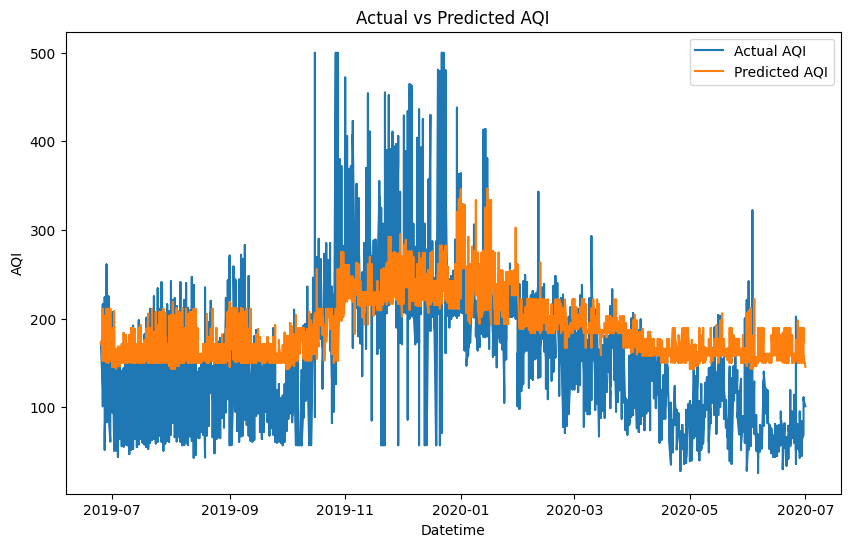

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+-------+---+------------------+
|   City|aqi|        prediction|
+-------+---+------------------+
|Lucknow|132|138.73597022239022|
|Lucknow|145|153.76500874035008|
|Lucknow|154|153.76500874035008|
|Lucknow|144|153.76500874035008|
|Lucknow|142|153.76500874035008|
|Lucknow|153|138.73597022239022|
|Lucknow|165| 155.6363539286837|
|Lucknow|178| 155.6363539286837|
|Lucknow|185| 155.6363539286837|
|Lucknow|188|153.76500874035008|
|Lucknow|183|138.73597022239022|
|Lucknow|174|153.76500874035008|
|Lucknow|179|153.76500874035008|
|Lucknow|180|138.73597022239022|
|Lucknow|177| 134.3246833555922|
|Lucknow|175|153.76500874035008|
|Lucknow|187|153.76500874035008|
|Lucknow|206| 162.9546090637851|
|Lucknow|206| 162.9546090637851|
|Lucknow|210| 162.9546090637851|
+-------+---+-

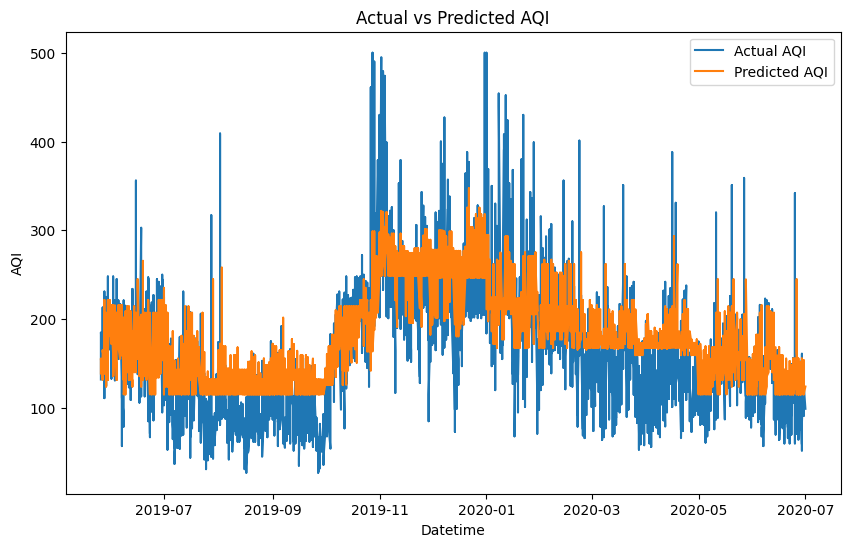

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+------+---+-----------------+
|  City|aqi|       prediction|
+------+---+-----------------+
|Mumbai| 66|71.28829859807686|
|Mumbai| 59|71.28829859807686|
|Mumbai| 71|71.28829859807686|
|Mumbai| 83| 77.6243648103456|
|Mumbai| 68|71.28829859807686|
|Mumbai| 68|71.28829859807686|
|Mumbai| 59|69.33681466446103|
|Mumbai| 61|69.33681466446103|
|Mumbai| 76|69.33681466446103|
|Mumbai| 56|69.02663304823037|
|Mumbai| 40|69.02663304823037|
|Mumbai| 60|69.02663304823037|
|Mumbai| 60|69.02663304823037|
|Mumbai| 65|69.02663304823037|
|Mumbai| 54|69.02663304823037|
|Mumbai| 60|69.02663304823037|
|Mumbai| 55|73.90190885398312|
|Mumbai| 45|74.16314064138722|
|Mumbai| 55|74.16314064138722|
|Mumbai| 55|74.16314064138722|
+------+---+-----------------+
only showing top 20 rows



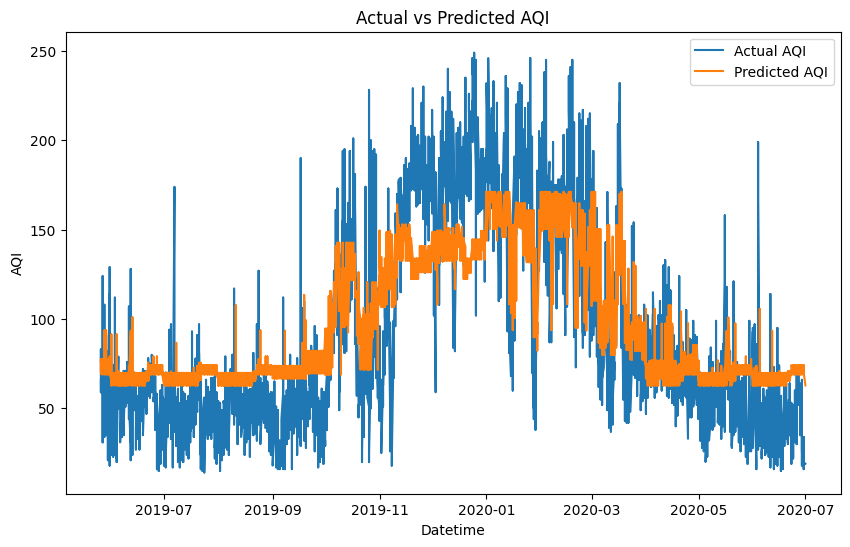

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+-------+---+------------------+
|   City|aqi|        prediction|
+-------+---+------------------+
|Kolkata|160|172.82458854483244|
|Kolkata|162|172.82458854483244|
|Kolkata|161|172.82458854483244|
|Kolkata|163|172.82458854483244|
|Kolkata|170|177.62628626739973|
|Kolkata|176|177.62628626739973|
|Kolkata|177|177.62628626739973|
|Kolkata|182|191.58430456793616|
|Kolkata|184|191.58430456793616|
|Kolkata|185|191.58430456793616|
|Kolkata|191|191.58430456793616|
|Kolkata|197|182.33478075841236|
|Kolkata|200|182.33478075841236|
|Kolkata|197|168.94337223100743|
|Kolkata|181|168.94337223100743|
|Kolkata|170|167.90734267752205|
|Kolkata|162|167.90734267752205|
|Kolkata|163|167.90734267752205|
|Kolkata|155|172.82458854483244|
|Kolkata|154|167.90734267752205|
+-------+---+-

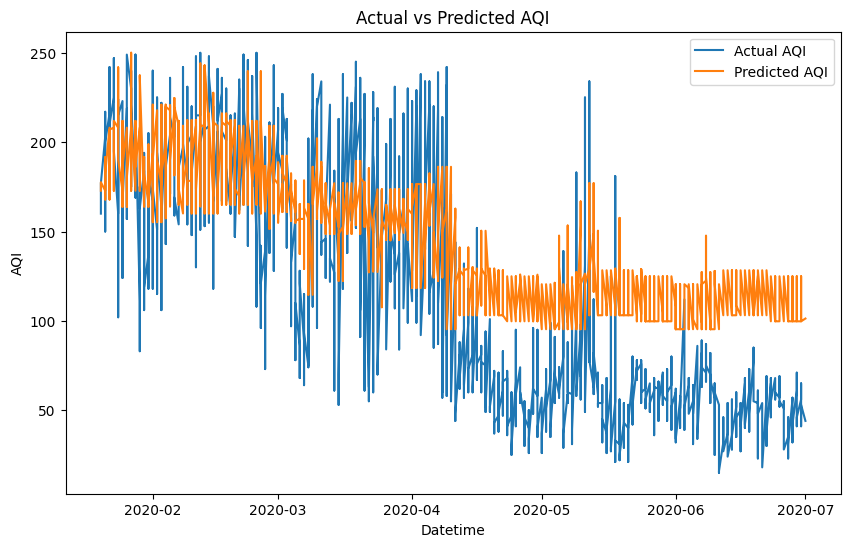

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+--------+---+-----------------+
|    City|aqi|       prediction|
+--------+---+-----------------+
|Shillong| 57|57.98322178638257|
|Shillong| 57|57.98322178638257|
|Shillong| 16|57.98322178638257|
|Shillong|  9|57.98322178638257|
|Shillong| 22| 58.6026050522403|
|Shillong| 33|90.57611659537517|
|Shillong| 48|90.57611659537517|
|Shillong| 51|90.57611659537517|
|Shillong| 77|90.57611659537517|
|Shillong| 57|90.57611659537517|
|Shillong| 43|89.17611659537516|
|Shillong| 29|93.91478412299891|
|Shillong| 38|93.91478412299891|
|Shillong| 39|93.91478412299891|
|Shillong| 32|85.87093166398252|
|Shillong| 34|85.29539196526238|
|Shillong| 20|85.29539196526238|
|Shillong| 18|85.29539196526238|
|Shillong| 51|85.29539196526238|
|Shillong| 32|85.29539196526238|
+--------+---+

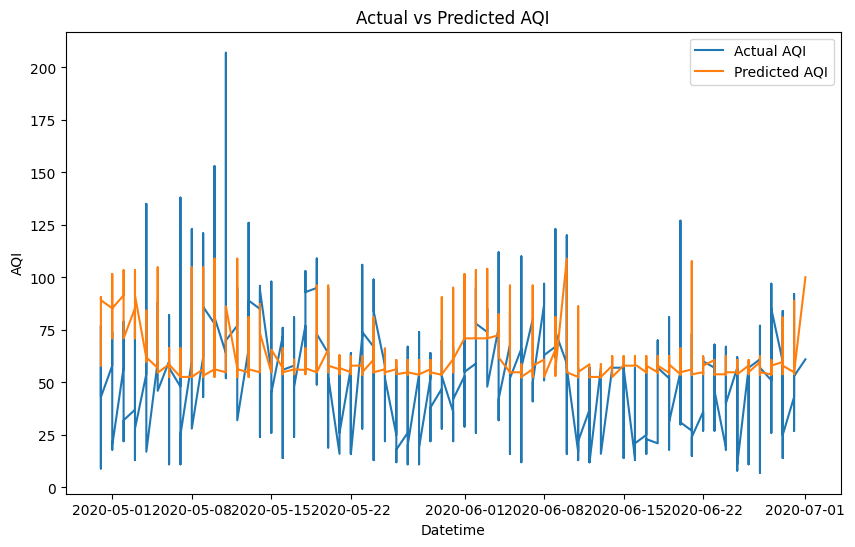

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+------------------+---+------------------+
|              City|aqi|        prediction|
+------------------+---+------------------+
|Thiruvananthapuram| 63| 66.68514470292229|
|Thiruvananthapuram| 57| 66.91092371071235|
|Thiruvananthapuram| 57| 81.32382487327597|
|Thiruvananthapuram| 57| 66.91092371071235|
|Thiruvananthapuram| 57|61.775895440932594|
|Thiruvananthapuram| 17| 68.70333832433356|
|Thiruvananthapuram| 29| 68.63580148313963|
|Thiruvananthapuram| 68|  95.6110950326603|
|Thiruvananthapuram| 68| 68.63580148313963|
|Thiruvananthapuram| 88| 68.63580148313963|
|Thiruvananthapuram| 45| 68.63580148313963|
|Thiruvananthapuram| 44| 68.63580148313963|
|Thiruvananthapuram| 42| 68.63580148313963|
|Thiruvananthapuram| 44| 68.63580148313963|
|Thiruvananthapuram| 57| 

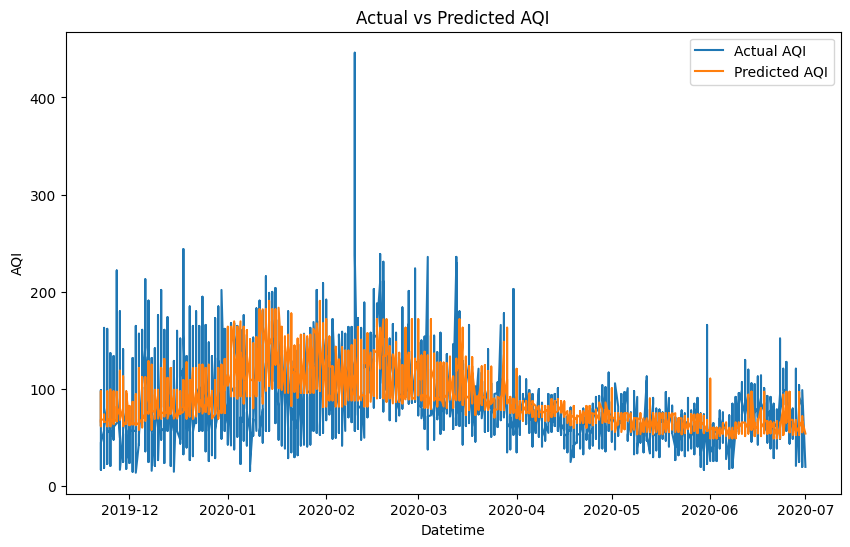

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+-------+---+------------------+
|   City|aqi|        prediction|
+-------+---+------------------+
|Talcher|117|122.18041500642917|
|Talcher|104|122.18041500642917|
|Talcher|102|122.18041500642917|
|Talcher|108|122.18041500642917|
|Talcher|207| 147.8800307779881|
|Talcher|219|185.24034623587696|
|Talcher|334| 174.3128832218749|
|Talcher|353|195.94400538994955|
|Talcher|270|195.94400538994955|
|Talcher|214|195.94400538994955|
|Talcher|265|195.94400538994955|
|Talcher|216| 184.8748930141778|
|Talcher|201| 184.8748930141778|
|Talcher|216| 184.8748930141778|
|Talcher|233| 184.8748930141778|
|Talcher|228| 184.8748930141778|
|Talcher|149|143.46781612734495|
|Talcher|133|157.27801737382234|
|Talcher|223|194.63833283171112|
|Talcher|286|176.65450282555048|
+-------+---+-

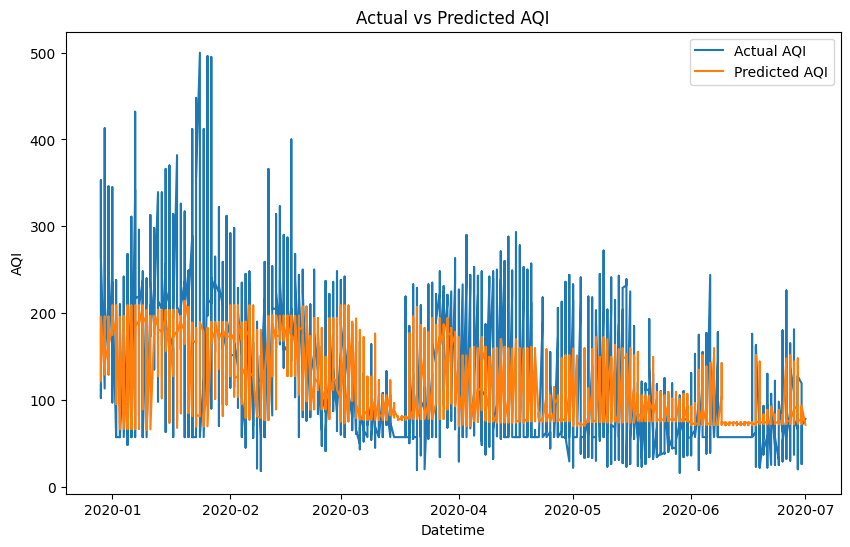

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+----------+---+------------------+
|      City|aqi|        prediction|
+----------+---+------------------+
|Jorapokhar|100| 135.5231121308836|
|Jorapokhar| 99| 135.5231121308836|
|Jorapokhar|113|137.14798446865916|
|Jorapokhar|134| 122.3816406429933|
|Jorapokhar|144| 122.3816406429933|
|Jorapokhar|138| 122.3816406429933|
|Jorapokhar|134| 122.3816406429933|
|Jorapokhar|126| 122.3816406429933|
|Jorapokhar|116|112.62496584689912|
|Jorapokhar|101|129.28311628345068|
|Jorapokhar|123|129.28311628345068|
|Jorapokhar|165|129.28311628345068|
|Jorapokhar|157|129.28311628345068|
|Jorapokhar|143|130.18946810565618|
|Jorapokhar|131|130.18946810565618|
|Jorapokhar|119|117.04799661776588|
|Jorapokhar|126|117.04799661776588|
|Jorapokhar|128|141.32984334017775|
|Jorapokhar|115|1

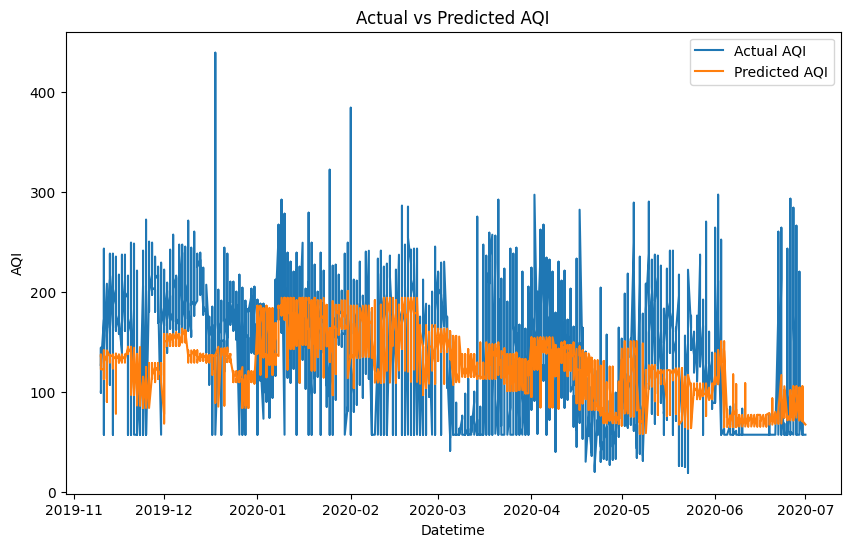

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+------+---+------------------+
|  City|aqi|        prediction|
+------+---+------------------+
|Jaipur|211|165.85947128836267|
|Jaipur|126| 133.3260397195698|
|Jaipur|129|128.84323937986468|
|Jaipur|144| 133.3260397195698|
|Jaipur|156|158.89480095869234|
|Jaipur|167|168.50445297334437|
|Jaipur|157|168.50445297334437|
|Jaipur|162|168.50445297334437|
|Jaipur|154|165.67339792922348|
|Jaipur|158|165.67339792922348|
|Jaipur|152|158.70872759955316|
|Jaipur|160| 133.1399663604306|
|Jaipur|136| 133.1399663604306|
|Jaipur|155| 133.1399663604306|
|Jaipur|157| 133.1399663604306|
|Jaipur|167|158.70872759955316|
|Jaipur|170|158.70872759955316|
|Jaipur|176|165.67339792922348|
|Jaipur|238|171.13377802113095|
|Jaipur|200|171.13377802113095|
+------+---+------------------+
only 

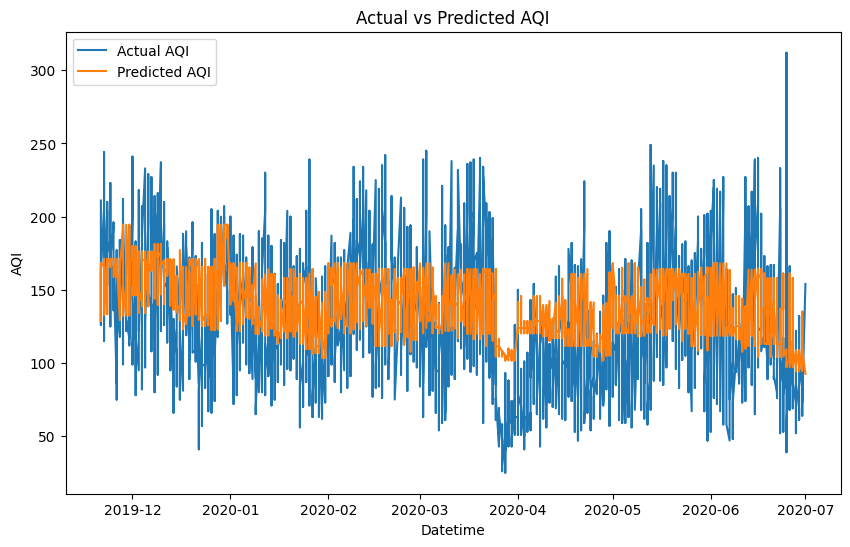

DataFrame[City: string, Datetime: timestamp, PM25: double, PM10: double, NO: double, NO2: double, NOx: double, NH3: double, CO: double, SO2: double, O3: double, AQI: int, year: int, month: int, day: int, hour: int, lag_1: int]
+-------------+---+------------------+
|         City|aqi|        prediction|
+-------------+---+------------------+
|Visakhapatnam| 74| 82.46884087127039|
|Visakhapatnam| 72| 87.23951398955586|
|Visakhapatnam| 79| 82.46884087127039|
|Visakhapatnam| 77| 94.43377733700324|
|Visakhapatnam| 91|107.76337274583948|
|Visakhapatnam|119|107.76337274583948|
|Visakhapatnam| 77|107.76337274583948|
|Visakhapatnam| 44| 82.46884087127039|
|Visakhapatnam| 70| 87.23951398955586|
|Visakhapatnam|113| 94.43377733700324|
|Visakhapatnam|117| 94.43377733700324|
|Visakhapatnam|107| 94.43377733700324|
|Visakhapatnam|102|107.76337274583948|
|Visakhapatnam|105|107.76337274583948|
|Visakhapatnam| 93|107.76337274583948|
|Visakhapatnam| 85|107.76337274583948|
|Visakhapatnam| 95|112.063888511

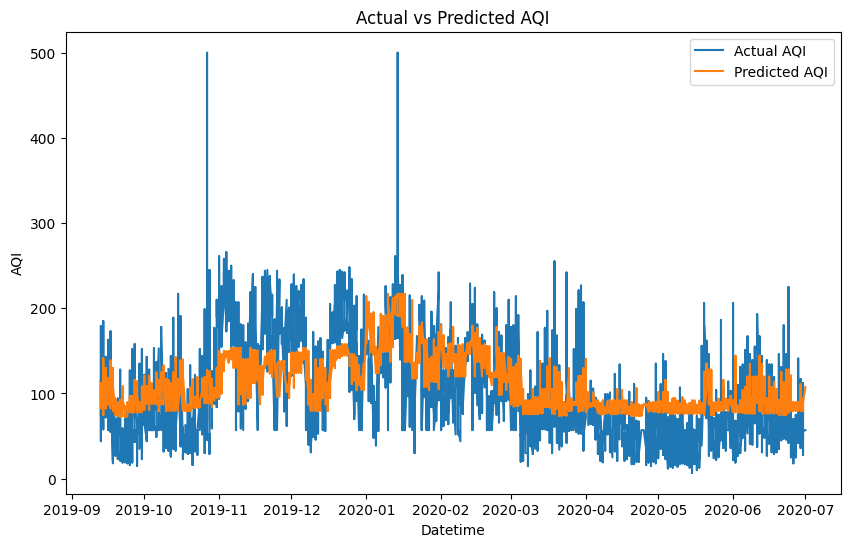

In [ ]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

# Create a window specification
windowSpec = Window.partitionBy("City").orderBy("Datetime")

for region, frame in region_data_frames.items():

  # Create lag features; here we lag by one day (assuming data is hourly and each day has 24 records)
  frame = frame.withColumn("lag_1", lag("AQI", 24).over(windowSpec))
  # Drop rows with nulls that were created by lagging
  frame = frame.na.drop()

  df = frame.sort(col("Datetime"))
  total_rows = df.count()
  cutoff_row = int(total_rows * 0.8)
  cutoff_date = df.select("Datetime").collect()[cutoff_row][0]

  # Split the data based on the cutoff date
  train_data = frame.where(col("Datetime") < cutoff_date)
  test_data = frame.where(col("Datetime") >= cutoff_date)
  print(train_data)
  model = pipeline.fit(train_data)

  # Predict on the test data
  predictions = model.transform(test_data)
  predictions.select("City", "aqi", "prediction").show()
  aqi_prediction(predictions)

### Conclusion

These features are not sufficient to predict the AQI values correctly. We need to capture seasonal effects, weather patterns etc to correctly predict the AQI values.
